# Project: Advanced Lane Finding

This project has been prepared by Andre Strobel.

The goal of this project is to find a vehicle's lane in a video stream. The video stream has been recorded with a forward facing camera that is mounted to the vehicle. The detected lane is then used to estimate the lateral curvature of the road.

Everything has ben programmed in Python 3.

## Content

1. Camera setup
    1. Distortion correction based on several test images
    1. Transformation to birds-eye view
    1. Pixel to real world transformation
1. Processing individual frames from a video stream to detect the lane and lateral curvature
    1. Generate binary images to detect lane lines using different methods and parameters
    1. Identify left and right lane lines with and without prior knowledge about their shape and positions
    1. Manage left and right lane line detection quality and determine what to use
1. Output a video stream that contains information about the lane ahead
    1. Mark up the lane ahead
    1. Mark up left and right lane lines with different color
    1. Print the lateral curvature value and lateral offset from the center of the lane

## Basic definitions

The following section defines a framework for the actual code of this project.

### Import all necessary libraries

This project uses the file globbing (`glob`), miscellaneous operating system interfaces (`os`), copying (`copy`), Open-CV (`cv2`) and NumPy (`numpy`) packages as well as several subpackages from the `matplotlib` package (`pyplot`, `image`). In order to process and display videos, the objects `VideoFileClip` and `ImageSequenceClip` are imported from the package `moviepy.editor` and the object `HTML` is imported from `IPython.display`.

In [1]:
import glob
import os
import copy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
from IPython.display import HTML

### Define exception handling

A generic exception class `Error` is defined to handle potential issues during the execution.

In [2]:
class Error(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

### Define classes

The class `Line` is defined to store previous findings of the left, right and all lane lines. The class `Lane` is defined to store previous findings of the lane.

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # starting peak positions
        self.startpeak = None
        
class Lane():
    def __init__(self):
        # last found lane_mask
        self.lane_mask = np.array([])

### Helper functions

The `weighted_image` function blends two images into one image. The `blendinto_image` function adds a second image to the first image. The `addto_image` function adds all non black pixels of an image to another image.

In [4]:
def weighted_image(image1, weight, image2):
# ...
# This function blends two images using the weight [0, 1] for the first image
# ...
# Inputs
# ...
# image1 : first image
# weight : weight used for first image - must be between 0 and 1
# image2 : second image
# ...
# Outputs
# ...
# blended : blended image
    
    # blend images
    blended = cv2.addWeighted(image1, weight, image2, (1 - weight), 0)
    
    return blended

def blendinto_image(image1, image2, weight):
# ...
# This function adds a second image to the first image using the weight [0, 1]
# ...
# Inputs
# ...
# image1 : first image
# image2 : second image
# weight : weight used to add the second image to the first image - must be between 0 and 1
# ...
# Outputs
# ...
# blended : blended image
    
    # blend images
    blended = cv2.addWeighted(image1, 1, image2, weight, 0)
    
    return blended

def addto_image(image, maskimage):
# ...
# This function adds all non-zero (non black) pixels of a second image to the first image
# ...
# Inputs
# ...
# image     : first image
# maskimage : second image
# ...
# Outputs
# ...
# ret      : boolean for "successful operation"
# combined : combined image
    
    # initialize output
    ret = True
    
    # copy first image
    combined = np.copy(image)
    
    # determine image size
    targetysize = combined.shape[0]
    targetxsize = combined.shape[1]
    targetcsize = combined.shape[2]
    
    # determine mask size
    ysize = maskimage.shape[0]
    xsize = maskimage.shape[1]
    csize = maskimage.shape[2]
    
    # combined image cannot be smaller than mask image
    if not ((targetysize < ysize) or (targetxsize < xsize) or (targetcsize < csize)):
        
        # replace all non-zero pixels
        for idxy, y in enumerate(range(ysize)):
            for idxx, x in enumerate(range(xsize)):
                if not ((maskimage[y, x, 0] == 0) and (maskimage[y, x, 1] == 0) and (maskimage[y, x, 2] == 0)):
                    combined[y, x, 0] = maskimage[y, x, 0]
                    combined[y, x, 1] = maskimage[y, x, 1]
                    combined[y, x, 2] = maskimage[y, x, 2]
        
    else:
        
        # return error flag
        ret = False
    
    return ret, combined

## Camera setup process

The camera setup defines a sequence of functions to correct and transform camaera images.

### Camera calibration

The `camera_calibration` function is based on the Open-CV tutorial (http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html) and Udacity tutorial (https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb).

In [5]:
def camera_calibration(calsubfolder = 'camera_cal', calimagemask = '*.jpg', numcalpicpointsx = 9, numcalpicpointsy = 6, bdisplay = False):
# ...
# This function calibrates a camera with numcalpicpointsx times numcalpicpointsy chessboard pictures
# in the subfolder calsubfolder based on images of the mask calimagemask
# ...
# Inputs
# ...
# calsubfolder     : folder with calibration images
# calimagemask     : name mask for calibration images
# numcalpicpointsx : number of chessboard elements in horizontal direction
# numcalpicpointsy : number of chessboard elements in vertical direction
# bdisplay         : boolean for "display outputs"
# ...
# Outputs
# ...
# ret   : boolean for "succesful execution"
# mtx   : camera matrix
# dist  : distortion coefficients
# rvecs : rotation vectors
# tvecs : translation vectors
  
    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('camera_calibration')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros(((numcalpicpointsy * numcalpicpointsx), 3), np.float32)
    objp[:, :2] = np.mgrid[0:numcalpicpointsx, 0:numcalpicpointsy].T.reshape(-1, 2)
    
    # arrays to store object points and image points from all the images
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane

    # get a list of calibration images
    fileimages = glob.glob(os.path.join('.', calsubfolder, calimagemask))

    # initialize variables
    images = []
    grays =[]
    corners =[]
    
    # loop through all images
    for idx, fileimage in enumerate(fileimages):
        
        # read image as gray scale
        images.append(mpimg.imread(fileimage))
        grays.append(cv2.cvtColor(images[idx], cv2.COLOR_BGR2GRAY))
        
        # find the chess board corners
        ret, newcorners = cv2.findChessboardCorners(grays[idx], (numcalpicpointsx, numcalpicpointsy), None)
        corners.append(newcorners)

        # if found, add object points, image points
        if ret == True:
            
            # add found corners to calibration lists
            objpoints.append(objp)
            imgpoints.append(corners[idx])
            
    # calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, grays[idx].shape[::-1], None, None)

    # draw and display marked and undistorted images
    if bdisplay:
    
        # loop through all images
        for idx, fileimage in enumerate(fileimages):
            
            # mark up corners in image
            print('Processing image:', fileimage)
            markedimage = cv2.drawChessboardCorners(images[idx], (numcalpicpointsx, numcalpicpointsy), corners[idx], True)
            undistortedimage = cv2.undistort(markedimage, mtx, dist, None, mtx)
            figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            figure.tight_layout()
            ax1.imshow(markedimage)
            ax1.set_title('Marked calibration image', fontsize=30)
            ax2.imshow(undistortedimage)
            ax2.set_title('Undistorted marked calibration image', fontsize=30)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()
    
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    return (ret, mtx, dist, rvecs, tvecs)

### Camera to birdseye view

The `camera2birdseyeview` function is based on the material from the Udacity SDC nanodegree.

In [6]:
def camera2birdseyeview(mtx, dist, testsubfolder = 'test_images', testimage = 'straight_lines1.jpg', testimagemask = '*.jpg', offsetxpercent = 30, offsetypercent = 0, bdisplay = False):
# ...
# This function calculates the transformations from camera to birdseye view and vice versa
# ...
# Inputs
# ...
# mtx            : camera matrix
# dist           : distortion coefficients
# testsubfolder  : folder with test image
# testimage      : test image name
# testimagemask  : name mask for test images
# offsetxpercent : x direction offset around transformation box in percent
# offsetypercent : y direction offset around transformation box in percent
# bdisplay       : boolean for "display outputs"
# ...
# Outputs
# ...
# ret : boolean for "succesful execution"
# M   : transformation matrix from camera to birdseye view
# N   : transformation matrix from birdseye view to camera

    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('camera2birdseyeview')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # constants
    drawweight = 0.8 # weight for adding area used for transformation
    linewidth = 10 # width of dimensions in image
    
    # initialize output
    ret = True
    
    # read and undistort test image based on which transformation will be determined
    fileimage = os.path.join('.', testsubfolder, testimage)
    image = mpimg.imread(fileimage)
    undistortedimage = cv2.undistort(image, mtx, dist, None, mtx)
    xsize = undistortedimage.shape[1]
    ysize = undistortedimage.shape[0]
    
    # manually define source points => look for algorithm in the future
    srcymin = 450
    srcymax = 720
    srcpoint_bottom_left_x = 200
    srcpoint_bottom_left_y = srcymax
    srcpoint_top_left_x = 594
    srcpoint_top_left_y = srcymin
    srcpoint_top_right_x = 685
    srcpoint_top_right_y = srcymin
    srcpoint_bottom_right_x = 1100
    srcpoint_bottom_right_y = srcymax
    src = np.float32([[srcpoint_bottom_left_x, srcpoint_bottom_left_y],
                      [srcpoint_top_left_x, srcpoint_top_left_y], 
                      [srcpoint_top_right_x, srcpoint_top_right_y], 
                      [srcpoint_bottom_right_x, srcpoint_bottom_right_y]])
    
    # define destination points
    dstxmin = 0 + (xsize * offsetxpercent / 100)
    dstxmax = xsize - 1 - (xsize * offsetxpercent / 100)
    dstymin = 0 + (ysize * offsetypercent / 100)
    dstymax = ysize - 1 - (ysize * offsetypercent / 100)
    dst = np.float32([[dstxmin, dstymax], [dstxmin, dstymin], [dstxmax, dstymin], [dstxmax, dstymax]])
    
    # calculate transformation matrices
    M = cv2.getPerspectiveTransform(src, dst)
    N = cv2.getPerspectiveTransform(dst, src)
    
    # draw and display test image and birdseye view image
    if bdisplay:
        
        # print name of used test image
        print('Processing image:', fileimage)
        
        # draw area used for transformation into original image
        points = np.int32(src.reshape((-1,1,2)))
        srcareaimage = np.zeros_like(undistortedimage)
        cv2.polylines(srcareaimage, [points], True, (0, 255, 0), thickness = linewidth)
        blended = blendinto_image(undistortedimage, srcareaimage, drawweight)
        
        # make perspective transformation of original image with area used for transformation
        xsize = blended.shape[1]
        ysize = blended.shape[0]        
        warpedimage = cv2.warpPerspective(blended, M, (xsize, ysize), flags=cv2.INTER_LINEAR)
        
        # draw area used for transformation into transformed image
        points = np.int32(dst.reshape((-1,1,2)))
        dstareaimage = np.zeros_like(warpedimage)
        cv2.polylines(dstareaimage, [points], True, (255, 0, 0), thickness = linewidth)
        ret, addedwarped = addto_image(warpedimage, dstareaimage)
        
        # plot original and transformed images
        figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        figure.tight_layout()
        ax1.imshow(blended)
        ax1.set_title('Image with area used for transformation', fontsize=30)
        ax2.imshow(addedwarped)
        ax2.set_title('Birdseye view test image', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
        
        # get a list of test images
        fileimages = glob.glob(os.path.join('.', testsubfolder, testimagemask))

        # loop through all images
        for idx, fileimage in enumerate(fileimages):
            
            # print name of used test image
            print('Processing image:', fileimage)
        
            # read next test image
            image = mpimg.imread(fileimage)
            undistortedimage = cv2.undistort(image, mtx, dist, None, mtx)
            xsize = undistortedimage.shape[1]
            ysize = undistortedimage.shape[0]
            
            # mark up corners in image
            warpedimage = cv2.warpPerspective(undistortedimage, M, (xsize, ysize), flags=cv2.INTER_LINEAR)
            figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            figure.tight_layout()
            ax1.imshow(undistortedimage)
            ax1.set_title('Original test image', fontsize=30)
            ax2.imshow(warpedimage)
            ax2.set_title('Birdseye view test image', fontsize=30)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()
            
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    return ret, M, N

### Pixels to real world

The `pixels2realworld` function is based on the material from the Udacity SDC nanodegree.

In [7]:
def pixels2realworld(mtx, dist, M, testsubfolder = 'test_images', testimage = 'straight_lines1.jpg', bdisplay = False):
# ...
# This function estimates the conversion from pixels to real world meters
# ...
# Inputs
# ...
# mtx            : camera matrix
# dist           : distortion coefficients
# M              : perspective transformation to birdseye view
# testsubfolder  : folder with test image
# testimage      : test image name
# bdisplay       : boolean for "display outputs"
# ...
# Outputs
# ...
# ret        : boolean for "succesful execution"
# xm_per_pix : conversion from pixels to meters in horizontal/lateral direction
# ym_per_pix : conversion from pixels to meters in vertical/longitudinal direction
    
    # display beginning of this function if necessary
    if bdisplay:
        
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('pixels2realworld')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # constants
    lanewidth = 3.7 # regulated minimum US lane width
    dashedline = 3 # length of dashed line
    dimensions_draw_offset = 100 # offset for drawing dimensions into image
    linewidth = 10 # width of dimensions in image
    
    # initialize output
    ret = True
    
    # read and undistort test image based on which conversion  will be determined
    fileimage = os.path.join('.', testsubfolder, testimage)
    image = mpimg.imread(fileimage)
    undistortedimage = cv2.undistort(image, mtx, dist, None, mtx)
    xsize = undistortedimage.shape[1]
    ysize = undistortedimage.shape[0]
    
    # transform the image to birdseye view
    warpedimage = cv2.warpPerspective(undistortedimage, M, (xsize, ysize), flags=cv2.INTER_LINEAR)
    
    # create binary image
    binary = create_binary_image(warpedimage, bhls_s = True, hls_s_thresh = (50, 255), bdisplay = False)
    
    # Calculate conversions based on test image information
    imagelanewidth = 450 # write code to detect the width of the lane in pixels in the test picture
    xm_per_pix = lanewidth / imagelanewidth
    imagedashedline = 70 # in the future write code to detect the length of a dashed line in pixels in the test image
    ym_per_pix = dashedline / imagedashedline
    
    # draw and display test image with detected lane width and horizon
    if bdisplay:
        
        # print name of used test image
        print('Processing image:', fileimage)
        
        # create binary color picture with dimensions added
        colorbinary = np.dstack((binary, binary, binary)) * 255
        dimensions = np.zeros_like(colorbinary)
        lanepointstartx = dimensions_draw_offset
        lanepointendx = dimensions_draw_offset + imagelanewidth
        lanepointstarty = ysize - dimensions_draw_offset
        lanepointendy = ysize - dimensions_draw_offset
        cv2.line(dimensions, (lanepointstartx, lanepointstarty), (lanepointendx, lanepointendy), (0, 255, 0) , thickness = linewidth)
        linepointstartx = dimensions_draw_offset
        linepointendx = dimensions_draw_offset
        linepointstarty = ysize - dimensions_draw_offset
        linepointendy = ysize - dimensions_draw_offset - imagedashedline
        cv2.line(dimensions, (linepointstartx, linepointstarty), (linepointendx, linepointendy), (255, 0, 0) , thickness = linewidth)
        ret, addedbinary = addto_image(colorbinary, dimensions)
        
        # plot original and processed image
        warpedimage = cv2.warpPerspective(undistortedimage, M, (xsize, ysize), flags=cv2.INTER_LINEAR)
        figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        figure.tight_layout()
        ax1.imshow(undistortedimage)
        ax1.set_title('Original test image', fontsize=30)
        ax2.imshow(addedbinary)
        ax2.set_title('Binary image to detect lane width and dashed line length', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
      
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    return ret, xm_per_pix, ym_per_pix

### Actual camera setup

The `camera setup` function combines all functions to determine the necessary image corrections and transformations due to the camera performance and installation.

In [8]:
def camera_setup(bdisplay = False):
# ...
# This function calls the necessary functions to determine all parameters to correct for camera performance
# and installation issues
# ...
# Inputs
# ...
# bdisplay : boolean for "display outputs"
# ...
# Outputs
# ...
# ret        : boolean for "succesful camera calibration"
# mtx        : camera matrix
# dist       : distortion coefficients
# rvecs      : rotation vectors
# tvecs      : translation vectors
# M          : transformation matrix from camera to birdseye view
# N          : transformation matrix from birdseye view to camera
# xm_per_pix : convertion from pixels to meters in horizontal/lateral direction
# ym_per_pix : convertion from pixels to meters in vertical/longitudinal direction
    
    # display beginning of this function if necessary
    if bdisplay:
        
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('camera_setup')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # determine distortion of camera
    ret, mtx, dist, rvecs, tvecs = camera_calibration(bdisplay = bdisplay)
    if not(ret):
        raise Error('Couldn\'t determine camera calibration')
    
    # determine transformation from camera to birdseye view
    ret, M, N = camera2birdseyeview(mtx, dist, bdisplay = bdisplay)
    if not(ret):
        raise Error('Couldn\'t determine transformation from camera to birdseye view')
    
    # determine transformation from pixels to real world
    ret, xm_per_pix, ym_per_pix = pixels2realworld(mtx, dist, M, bdisplay = bdisplay)
    if not(ret):
        raise Error('Couldn\'t determine convertion from pixels to real world')
        
    # display end of this function if necessary
    if bdisplay:
        
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    return mtx, dist, rvecs, tvecs, M, N, xm_per_pix, ym_per_pix

## Processing images to detect the lane and lateral curvature

The following section defines all functions that are necessary to process individual images to detect and mark up lanes. It also contains the functions that are necessary to determine the lateral lane curvature and the lateral offset from the center of the lane. There are also functions to decide whether or not prior knowledge can be used to simplify and improve lane detection.

### Generate binary images to detect lane lines using different methods and parameters

The `create_binary_image` function is based on the material from the Udacity SDC nanodegree and combines. It allows to combine different filters to generate a combined binary output channel. Several additional functions are defined to avoid repetition of the same code structure while allowing the flexibility for many different filters.

In [9]:
def do_sobel(channel, xdir, ydir, ksize):
# ...
# This function calculates the sobel value of a channel
# ...
# Inputs
# ...
# channel : color channel of an image
# xdir    : magnitude of x direction [0, 1]
# ydir    : magnitude of y direction [0, 1]
# ksize   : kernel size for sobel operation [1, 3, 5, ...]
# ...
# Outputs
# ...
# sobel : result of the sobel operation (same size as channel)
   
    # take the derivative
    sobel = cv2.Sobel(channel, cv2.CV_64F, xdir, ydir, ksize = ksize)
    
    return sobel

def absolute_channel(channel1, channel2 = None):
# ...
# This function calculates scaled absolute values for a channel using the magnitude if 2 channels are provided
# ...
# Inputs
# ...
# channel1 : channel 1 of an image
# channel2 : channel 2 of an image
# ...
# Outputs
# ...
# scaled_channel : scaled absolute channel
    
    if channel2 is None:
        # calculate absolute value
        abs_channel = (channel1 ** 2) ** 0.5
    else:
        # calculate magnitude
        abs_channel = ((channel1 ** 2) + (channel2 ** 2)) ** 0.5

    # scale to [0, 255]
    scaled_channel = 255 * abs_channel / np.max(abs_channel)
    
    return scaled_channel

def channel_direction(channelx, channely):
# ...
# This function calculates the combined direction of an x and y channel
# ...
# Inputs
# ...
# channelx : x derivative of color channel
# channely : y derivative of color channel
# ...
# Outputs
# ...
# direction : direction of combined channels
   
    # calculate direction
    direction = np.arctan2(channely, channelx)
    
    return direction

def apply_threshold(channel, thresh):
# ...
# This function applies a threshold to a channel and returns a binary channel
# ...
# Inputs
# ...
# channel : channel of an image
# thresh  : minimum and maximum threshold values
# ...
# Outputs
# ...
# binary : binary channel
   
    # generate a binary channel based on provided thresholds
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    binary = np.uint8(binary)
    
    return binary

def calculate_sobels(template, channel, bmag, bdir, bsobelx, bsobely, sobel_kernel, mag_thresh, dir_thresh, sobelx_thresh, sobely_thresh):
# ...
# This function applies a threshold to a channel and returns a binary channel
# ...
# Inputs
# ...
# template      : template output depending on OR (zeros) or AND (ones) connection later
# channel       : channel of an image
# bmag          : boolean for "process magnitude"
# bdir          : boolean for "process direction"
# bsobelx       : boolean for "process sobel in x"
# bsobely       : boolean for "process sobel in y"
# sobel_kernel  : sobel kernel size
# mag_thresh    : threshold for magnitude
# dir_thresh    : threshold for direction
# sobelx_thresh : threshold for sobel in x direction
# sobely_thresh : threshold for sobel in y direction
# ...
# Outputs
# ...
# mag_binary : binary channel for magnitude
# dir_binary : binary channel for direction
# sx_binary  : binary channel for sobel in x
# sy_binary  : binary channel for sobel in y
    
    # initialize outputs
    mag_binary = np.copy(template)
    dir_binary = np.copy(template)
    sx_binary = np.copy(template)
    sy_binary = np.copy(template)
    
    if (bmag or bdir or bsobelx):
        sobelx = do_sobel(channel, 1, 0, sobel_kernel)
    if (bmag or bdir or bsobely):
        sobely = do_sobel(channel, 0, 1, sobel_kernel)
    if bmag:
        mag_binary = apply_threshold(absolute_channel(sobelx, sobely), mag_thresh)
    if bdir:
        dir_binary = apply_threshold(channel_direction(sobelx, sobely), dir_thresh)
    if bsobelx:
        sx_binary = apply_threshold(absolute_channel(sobelx), sobelx_thresh)
    if bsobely:
        sy_binary = apply_threshold(absolute_channel(sobely), sobely_thresh)
    
    return mag_binary, dir_binary, sx_binary, sy_binary

def cbi(binary_list, bOR = True, bdisplay = False):
# ...
# This function combined a list of binaries using AND or OR
# ...
# Inputs
# ...
# binary_list : list of binary images
# bOR         : boolean for "use OR operator"
# bdisplay    : boolean for "display outputs"
# ...
# Outputs
# ...
# binary : combined binary image
    
    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('cbi (combine binary image)')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    # initialize outputs
    if bOR:
        binary = np.zeros_like(binary_list[0])
    else:
        binary = np.ones_like(binary_list[0])
    
    # process all elements in binary list
    elementshape = []
    for idx, current_binary in enumerate(binary_list):
        
        # start combining with second binary
        if (idx > 0):
            
            # make sure shapes match
            if (current_binary.shape == elementshape):
                
                # combine current binary with output
                if bOR:
                    binary = (binary | current_binary)
                else:
                    binary = (binary & current_binary)
                
            else:
                
                raise Error('Binary shapes don\'t match')
                
        else:
            
            # use first binary as start
            binary = current_binary
            
            # remember first binary shape
            elementshape = current_binary.shape
        
    # display two images and result
    if (bdisplay and (idx == 1)):
        
        # print name of used test image
        print('Processing image size:', binary.shape)
        
        # print information
        if bOR:
            operator_string = 'OR'
        else:
            operator_string = 'AND'
        print('Binary operator used for combining:', operator_string)
        
        # draw original image with lane and lane mask
        figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))
        figure.tight_layout()
        ax1.imshow(binary_list[0], cmap='gray')
        ax1.set_title('First binary image', fontsize=20)
        ax2.imshow(binary_list[1], cmap='gray')
        ax2.set_title('Second binary image', fontsize=20)
        ax3.imshow(binary, cmap='gray')
        ax3.set_title('Combined binary image', fontsize=20)
        ax4.imshow(np.zeros_like(binary), cmap='gray')
        ax4.set_title('<Empty>', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

    # display end of function
    if bdisplay:
        
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    return binary

def create_binary_image(image, bOR = False,
                        bgray = False, gray_thresh = (180, 255),
                        bgray_mag = False, bgray_dir = False, bgray_sx = False, bgray_sy = False,
                        gray_sobel_kernel = 15, gray_mag_thresh=(100, 255), gray_dir_thresh = (0 + 0.5, (np.pi / 2) - 0.5),
                        gray_sx_thresh = (70, 120), gray_sy_thresh = (100, 255), 
                        bhls_h = False, hls_h_thresh = (15, 50),
                        bhls_h_mag = False, bhls_h_dir = False, bhls_h_sx = False, bhls_h_sy = False, 
                        hls_h_sobel_kernel = 15, hls_h_mag_thresh=(100, 255), hls_h_dir_thresh = (0 + 0.5, (np.pi / 2) - 0.5), 
                        hls_h_sx_thresh = (50, 150), hls_h_sy_thresh = (80, 200), 
                        bhls_l = False, hls_l_thresh = (140, 255), 
                        bhls_l_mag = False, bhls_l_dir = False, bhls_l_sx = False, bhls_l_sy = False, 
                        hls_l_sobel_kernel = 15, hls_l_mag_thresh=(30, 100), hls_l_dir_thresh = (0 + 0.5, (np.pi / 2) - 0.5), 
                        hls_l_sx_thresh = (30, 255), hls_l_sy_thresh = (50, 200), 
                        bhls_s = False, hls_s_thresh = (50, 255), 
                        bhls_s_mag = False, bhls_s_dir = False, bhls_s_sx = False, bhls_s_sy = False, 
                        hls_s_sobel_kernel = 15, hls_s_mag_thresh=(40, 255), hls_s_dir_thresh = (0 + 0.5, (np.pi / 2) - 0.5), 
                        hls_s_sx_thresh = (50, 255), hls_s_sy_thresh = (50, 255), 
                        bdisplay = False):
# ...
# This function creates a binary image applying a combination of algorithms to detect edges
# ...
# Inputs
# ...
# <channel>              = placeholder for channel out of set {gray, hls_h, hls_l, hls_s}
# image                  : RGB image
# b<channel>             : boolean for "process channel"
# <channel>_thresh       : threshold for color channel
# b<channel>_mag         : boolean for "process magnitude"
# b<channel>_dir         : boolean for "process direction"
# b<channel>_sx          : boolean for "process sobel in x"
# b<channel>_sy          : boolean for "process sobel in y"
# <channel>_sobel_kernel : sobel kernel size
# <channel>_mag_thresh   : threshold for magnitude
# <channel>_dir_thresh   : threshold for direction
# <channel>_sx_thresh    : threshold for sobel in x direction
# <channel>_sy_thresh    : threshold for sobel in y direction
# bdisplay               : boolean for "display outputs"
# ...
# Outputs
# ...
# combined_binary : combined binary channel
    
    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('create_binary_image')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    # copy image to not change original
    image = np.copy(image)
    
    # initialize intermediate outputs
    output_template = image[:, : , 0]
    if bOR:
        template = np.zeros_like(output_template)
    else:
        template = np.ones_like(output_template)
    gray_binary = np.copy(template)
    gray_mag_binary = np.copy(template)
    gray_dir_binary = np.copy(template)
    gray_sx_binary = np.copy(template)
    gray_sy_binary = np.copy(template)
    hls_h_binary = np.copy(template)
    hls_h_mag_binary = np.copy(template)
    hls_h_dir_binary = np.copy(template)
    hls_h_sx_binary = np.copy(template)
    hls_h_sy_binary = np.copy(template)
    hls_l_binary = np.copy(template)
    hls_l_mag_binary = np.copy(template)
    hls_l_dir_binary = np.copy(template)
    hls_l_sx_binary = np.copy(template)
    hls_l_sy_binary = np.copy(template)
    hls_s_binary = np.copy(template)
    hls_s_mag_binary = np.copy(template)
    hls_s_dir_binary = np.copy(template)
    hls_s_sx_binary = np.copy(template)
    hls_s_sy_binary = np.copy(template)
    
    # convert image to all necessary color spaces
    if (bgray or bgray_mag or bgray_dir or bgray_sx or bgray_sy):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if (bhls_h or bhls_h_mag or bhls_h_dir or bhls_h_sx or bhls_h_sy or 
          bhls_l or bhls_l_mag or bhls_l_dir or bhls_l_sx or bhls_l_sy or 
          bhls_s or bhls_s_mag or bhls_s_dir or bhls_s_sx or bhls_s_sy):
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        hls_h = hls[:,:,0]
        hls_l = hls[:,:,1]
        hls_s = hls[:,:,2]
    
    # calculate all necessary derivatives
    if (bgray_mag or bgray_dir or bgray_sx or bgray_sy):
        gray_mag_binary, gray_dir_binary, gray_sx_binary, gray_sy_binary = calculate_sobels(template, 
            gray, bgray_mag, bgray_dir, bgray_sx, bgray_sy, gray_sobel_kernel, 
            gray_mag_thresh, gray_dir_thresh, gray_sx_thresh, gray_sy_thresh)
    if (bhls_h_mag or bhls_h_dir or bhls_h_sx or bhls_h_sy):
        hls_h_mag_binary, hls_h_dir_binary, hls_h_sx_binary, hls_h_sy_binary = calculate_sobels(template, 
            hls_h, bhls_h_mag, bhls_h_dir, bhls_h_sx, bhls_h_sy, hls_h_sobel_kernel, 
            hls_h_mag_thresh, hls_h_dir_thresh, hls_h_sx_thresh, hls_h_sy_thresh)
    if (bhls_l_mag or bhls_l_dir or bhls_l_sx or bhls_l_sy):
        hls_l_mag_binary, hls_l_dir_binary, hls_l_sx_binary, hls_l_sy_binary = calculate_sobels(template, 
            hls_l, bhls_l_mag, bhls_l_dir, bhls_l_sx, bhls_l_sy, hls_l_sobel_kernel, 
            hls_l_mag_thresh, hls_l_dir_thresh, hls_l_sx_thresh, hls_l_sy_thresh)
    if (bhls_s_mag or bhls_s_dir or bhls_s_sx or bhls_s_sy):
        hls_s_mag_binary, hls_s_dir_binary, hls_s_sx_binary, hls_s_sy_binary = calculate_sobels(template, 
            hls_s, bhls_s_mag, bhls_s_dir, bhls_s_sx, bhls_s_sy, hls_s_sobel_kernel, 
            hls_s_mag_thresh, hls_s_dir_thresh, hls_s_sx_thresh, hls_s_sy_thresh)
    
    # apply necessary color channel thresholds
    if bgray:
        gray_binary = apply_threshold(gray, gray_thresh)
    if bhls_h:
        hls_h_binary = apply_threshold(hls_h, hls_h_thresh)
    if bhls_l:
        hls_l_binary = apply_threshold(hls_l, hls_l_thresh)
    if bhls_s:
        hls_s_binary = apply_threshold(hls_s, hls_s_thresh)
        
    # combine channels
    if bOR:
        combined_gray_binary = (gray_binary | gray_mag_binary | gray_dir_binary | gray_sx_binary | gray_sy_binary)
        combined_hls_h_binary = (hls_h_binary | hls_h_mag_binary | hls_h_dir_binary | hls_h_sx_binary | hls_h_sy_binary)
        combined_hls_l_binary = (hls_l_binary | hls_l_mag_binary | hls_l_dir_binary | hls_l_sx_binary | hls_l_sy_binary)
        combined_hls_s_binary = (hls_s_binary | hls_s_mag_binary | hls_s_dir_binary | hls_s_sx_binary | hls_s_sy_binary)
        combined_channel_binary = (gray_binary | hls_h_binary | hls_l_binary | hls_s_binary)
        combined_mag_binary = (gray_mag_binary | hls_h_mag_binary | hls_l_mag_binary | hls_s_mag_binary)
        combined_dir_binary = (gray_dir_binary | hls_h_dir_binary | hls_l_dir_binary | hls_s_dir_binary)
        combined_sx_binary = (gray_sx_binary | hls_h_sx_binary | hls_l_sx_binary | hls_s_sx_binary)
        combined_sy_binary = (gray_sy_binary | hls_h_sy_binary | hls_l_sy_binary | hls_s_sy_binary)
        combined_s_binary = (combined_sx_binary | combined_sy_binary)
        combined_binary = (combined_channel_binary | combined_mag_binary | combined_dir_binary | combined_s_binary)
    else:
        combined_gray_binary = (gray_binary & gray_mag_binary & gray_dir_binary & gray_sx_binary & gray_sy_binary)
        combined_hls_h_binary = (hls_h_binary & hls_h_mag_binary & hls_h_dir_binary & hls_h_sx_binary & hls_h_sy_binary)
        combined_hls_l_binary = (hls_l_binary & hls_l_mag_binary & hls_l_dir_binary & hls_l_sx_binary & hls_l_sy_binary)
        combined_hls_s_binary = (hls_s_binary & hls_s_mag_binary & hls_s_dir_binary & hls_s_sx_binary & hls_s_sy_binary)
        combined_channel_binary = (gray_binary & hls_h_binary & hls_l_binary & hls_s_binary)
        combined_mag_binary = (gray_mag_binary & hls_h_mag_binary & hls_l_mag_binary & hls_s_mag_binary)
        combined_dir_binary = (gray_dir_binary & hls_h_dir_binary & hls_l_dir_binary & hls_s_dir_binary)
        combined_sx_binary = (gray_sx_binary & hls_h_sx_binary & hls_l_sx_binary & hls_s_sx_binary)
        combined_sy_binary = (gray_sy_binary & hls_h_sy_binary & hls_l_sy_binary & hls_s_sy_binary)
        combined_s_binary = (combined_sx_binary & combined_sy_binary)
        combined_binary = (combined_channel_binary & combined_mag_binary & combined_dir_binary & combined_s_binary)
    combined_color_binary = np.dstack((combined_binary, combined_binary, combined_binary)) * 255
    combined_color_channel_binary = np.dstack((combined_channel_binary, combined_channel_binary, combined_channel_binary)) * 255
    combined_color_magdirs_binary = np.dstack((combined_mag_binary, combined_dir_binary, combined_s_binary)) * 255

    # draw and display image and combined binary image
    if bdisplay:
    
        # print name of used test image
        print('Processing image size:', image.shape)
        
        # compare original and binary image
        figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 9))
        figure.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Original image', fontsize=20)
        ax2.imshow(combined_color_binary)
        ax2.set_title('Combined binary image', fontsize=20)
        ax3.imshow(combined_color_channel_binary)
        ax3.set_title('Combined channel binary image', fontsize=20)
        ax4.imshow(combined_color_magdirs_binary)
        ax4.set_title('Combined Mag Dir S binary image', fontsize=20)
        plt.show()     

        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    return combined_binary

### Identify left and right lane lines with and without prior knowledge about their shape and positions

The `sliding_window_detect` function can be called to detect lane, lane lines, lateral curvature and lateral offset from the center of the lane within a binary image with or without prior knowledge about the lane lines. It is based on the material from the Udacity SDC nanodegree.

In [10]:
def detect_x_peak(binary, xmin, xmax, ymin, ymax, conv_width, bdisplay = False):
# ...
# This function detects peaks in x values of a binary image
# ...
# Inputs
# ...
# binary     : binary image
# xmin       : left corner of detection box relative to image
# xmax       : right corner of detection box relative to image
# ymin       : top corner of detection box relative to image
# ymax       : bottom corner of detection box relative to image
# conv_width : convolution window size
# bdisplay   : boolean for "display outputs"
# ...
# Outputs
# ...
# xpeak : x position of peak in image
# ypeak : y position of peak in image
# ret   : boolean for "successful operation"
    
    # constants
    min_conv_sum = (5 * 40) # line must be 5 pixels wide and 40 pixels high
    peak_stand_out = 10 # percent of how much a line peak must stand out of the histogram to be valid
    top_stand_out = 50 # percent of how much a close peak area must cover from the top points in the histogram
    
    # initialize output
    xpeak = np.int(xmin + ((xmax - xmin) // 2))
    ypeak = np.int(ymin + ((ymax - ymin) // 2))
    ret = True
    
    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('detect_x_peak')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # initial calculations
    window = np.ones(conv_width) # convolution window
    offset = np.int(conv_width // 2)
    closeconvwidth = np.int(conv_width // 1)
    
    # generate histogram
    histogram = np.sum(binary[ymin:ymax, xmin:xmax], axis = 0)
    
    # check whether histogram is not empty
    if (len(histogram) > 0):
        
        # execute convolution
        convolution = np.convolve(window, histogram)
        
        # detect peak
        maximum = np.argmax(convolution)
        potential_xpeak = np.int(maximum - offset + xmin)
        
        # check for valid data set
        convolution_sum = np.sum(convolution)
        b_valid_data_set = (convolution_sum >= min_conv_sum)
        
        # detect valid peak (small area around peak should have most points)
        maxconv = max(convolution)
        maxconvidx = maximum
        mincloseconvidx = np.int(max(0, (maxconvidx - (closeconvwidth // 2))))
        maxcloseconvidx = np.int(min((maxconvidx + (closeconvwidth // 2)), len(convolution)))
        closeconv = convolution[mincloseconvidx:maxcloseconvidx]
        convlimit = (maxconv * (1 - (peak_stand_out / 100)))
        top_closeconv = closeconv[closeconv > convlimit]
        top_closeconv_sum = np.sum(top_closeconv)
        top_conv = convolution[convolution > convlimit]
        top_conv_sum = np.sum(top_conv)
        top_conv_ratio = (top_closeconv_sum / top_conv_sum)
        b_valid_peak = (top_conv_ratio >= (1 - (top_stand_out / 100)))
        
        # detect whether peak is in search range
        b_peak_in_range = ((xmin <= potential_xpeak) and (potential_xpeak <= xmax))
    
    else:
        
        b_valid_data_set = False
        b_valid_peak = False
        b_peak_in_range = False
    
    # success is valid data set and valid peak
    if (b_valid_data_set and b_valid_peak and b_peak_in_range):
        
        # use peak position
        xpeak = potential_xpeak
        
        # calculate y value of peak if there are valid values
        ycontributing = np.arange(ymin, ymax) * binary[ymin:ymax, xpeak]
        ycontributing = ycontributing[np.nonzero(ycontributing)]
        if len(ycontributing):
            ypeak = np.int(np.average(ycontributing))
        
    else:
        
        # impossible to find a valid peak
        ret = False
        
    # draw and display image and combined binary image
    if bdisplay:
        
        # display information about findings
        if ret:
            print('Peak found at:', maximum)
            print('x coordinate of peak is:', xmin, '<=', xpeak, '<=', xmax)
            print('y coordinate of peak is:', ymin, '<=', ypeak, '<=', ymax)
        else:
            print('No peak found.')
        print('Convolution sum is:', convolution_sum)
        print('Minimum sum is:', min_conv_sum)
        print('Top peak percentage coverage is:', top_conv_ratio)
    
        # draw original image and image with findings
        figure, ax1 = plt.subplots(1, 1, figsize=(24, 9))
        figure.tight_layout()
        ax1.plot(histogram)
        ax1.plot(convolution)
        ax1.plot(convlimit * np.ones_like(convolution))
        ax1.axvline(x=mincloseconvidx)
        ax1.axvline(x=maxcloseconvidx)
        ax1.set_title('Histogram and convolution', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    return ret, xpeak, ypeak

def calculate_polynomial(line_centers, bdisplay):
# ...
# This function generates polynomials based on line centers
# ...
# Inputs
# ...
# line_centers : list of points of a line
# bdisplay     : boolean for "display outputs"
# ...
# Outputs
# ...
# line_poly : polynomial coefficients of calculated polynomial
    
    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('calculate_polynomial')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # get x values
    xvalues = []
    for idx, point in enumerate(line_centers):
        xvalues.append(point[0])
    
    # get y values
    yvalues = []
    for idx, point in enumerate(line_centers):
        yvalues.append(point[1])
    
    # fit a second order polynomial
    line_poly = np.polyfit(yvalues, xvalues, 2)
    
    # display information
    if bdisplay:
        
        # display information about findings
        print('Values in x:', xvalues)
        print('Values in y:', yvalues)
        print('Polynomial:', line_poly)

        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    return line_poly

def smooth_vector(new_vector, new_percentage, old_vector):
# ...
# This function smoothes a vector using a running average
# ...
# Inputs
# ...
# new_vector     : new value
# new_percentage : percentage of how much to use new value when smoothing
# old_vector     : previous smoothed value
# ...
# Outputs
# ...
# smoothed : smoothed value
    
    smoothed = ((new_percentage / 100) * new_vector) + ((1 - (new_percentage / 100)) * old_vector)
    
    return smoothed
    
def sliding_window_detect(binary, OldLeftLine, OldRightLine, OldAllLines, xm_per_pix, ym_per_pix, breusepoly = False, breusestart = False, bsmooth = False, bdisplay = False, bdisplaydetails = False, bdisplaydepth = False):
# ...
# This function detects left and right lines in a binary image
# ...
# Inputs
# ...
# binary          : binary image
# OldLeftLine     : previous left line information
# OldRightLine    : previous right line information
# OldAllLines     : all previous line information
# xm_per_pix      : convertion from pixels to meters in horizontal/lateral direction
# ym_per_pix      : convertion from pixels to meters in vertical/longitudinal direction
# breusepoly      : boolean for "reuse last polynomial"
# breusestart     : boolean for "reuse last starting position"
# bsmooth         : boolean for "smooth polynomials"
# bdisplay        : boolean for "display outputs"
# bdisplaydetails : boolean for "display detailed outputs"
# bdisplaydepth   : boolean for "display all detailed outputs"
# ...
# Outputs
# ...
# ret                      : boolean for "successful operation"
# line_centers             : list of left and right line centers
# valid_line_centers_left  : list of valid left line centers
# valid_line_centers_right : list of valid right line centers
# NewLeftLine              : left line information
# NewRightLine             : right line information
# lane_mask                : lane mask image used to overlay lane and lane lines in image

    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('sliding_window_detect')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # constants
    xstartminpercent = 10 # percentage of left corner of box to find lines relative to image
    xstartmaxpercent = 90 # percentage of right corner of box to find lines relative to image
    ystartminpercent = 70 # percentage of top corner of box to find lines relative to image
    ystartmaxpercent = 100 # percentage of bottom corner of box to find lines relative to image
    windowlevels = 9 # number of sliding windows
    margin = 80 # 100 # set the width of the windows +/- margin
    conv_width = 50 # window width for convolution
    boxeswidth = 5 # width of boxes
    centerwidth = 10 # width of center lines
    line_marker_width = 50 # width of line markers in output
    with_knowledge_minimum_line_centers_percent = 85  # percentage of minimum line centers for successful operation (nearly all to be able to reuse last fit)
    without_knowledge_minimum_line_centers = (3 + 1) # minimum line centers for successful operation (3 for polynomial plus 1 to not overfit)
    new_percentage = 25 # percentage of how much new polynomial influences used polynomial
    
    # initial calculations
    xsize = binary.shape[1]
    ysize = binary.shape[0]
    window_height = np.int(ysize // windowlevels)
    offset = np.int(conv_width / 2)
    initialcenterwidth = 2 * centerwidth
    with_knowledge_minimum_line_centers = np.int(windowlevels * (with_knowledge_minimum_line_centers_percent / 100))
    
    # initialize output
    ret = False
    line_centers =[]
    valid_line_centers_left =[]
    valid_line_centers_right =[]
    all_valid_line_centers = []
    NewLeftLine = Line() # copy.deepcopy(OldLeftLine)
    NewRightLine = Line() # copy.deepcopy(OldRightLine)
    NewAllLines = Line() # copy.deepcopy(OldAllLines)
    
    # calculate search box
    xmin = np.int(xsize * xstartminpercent / 100)
    xmax = np.int(xsize * xstartmaxpercent / 100)
    ymin = np.int(ysize * ystartminpercent / 100)
    ymax = np.int(ysize * ystartmaxpercent / 100)
    xminleft = xmin
    xmaxleft = xmin + np.int((xmax - xmin) // 2)
    xminright = xmaxleft
    xmaxright = xmax
    
    # initialize success variable 
    bstartingpositionsfound = False
    
    # reuse start positions
    if breusestart:
        
        # retrieve start peaks
        xpeak_left, ypeak_left = OldLeftLine.startpeak
        xpeak_right, ypeak_right = OldRightLine.startpeak
        
        # save start peaks
        NewLeftLine.startpeak = (xpeak_left, ypeak_left)
        NewRightLine.startpeak = (xpeak_right, ypeak_right)
        
        # return success
        bstartingpositionsfound = True
    
    else:
    
        # find starting lines
        ret_left, xpeak_left, ypeak_left = detect_x_peak(binary, xminleft, xmaxleft, ymin, ymax, conv_width, bdisplaydepth)
        ret_right, xpeak_right, ypeak_right = detect_x_peak(binary, xminright, xmaxright, ymin, ymax, conv_width, bdisplaydepth)
        
        # check for success
        if (ret_left and ret_right):
            
            # save start peaks
            NewLeftLine.startpeak = (xpeak_left, ypeak_left)
            NewRightLine.startpeak = (xpeak_right, ypeak_right)
            
            # return success
            bstartingpositionsfound = True
            
        else:
            
            # return no success
            bstartingpositionsfound = False
    
    # check whether starting position could be found
    if bstartingpositionsfound:
            
        # calculate lateral lane marker distance
        #lineoffset = (xpeak_right - xpeak_left)
        #offcenter = ((xpeak_left - 0) - (xsize - xpeak_right))
    
        # add boxes to display image if necessary
        if bdisplay:
                
            # create color image from binary image
            binary_draw = np.dstack((binary, binary, binary)) * 255
                
            # draw initial lines and boxes
            cv2.line(binary_draw, (xpeak_left, ypeak_left), (xpeak_left, ymax), (0, 255, 0) , thickness = initialcenterwidth)
            cv2.line(binary_draw, (xpeak_right, ypeak_right), (xpeak_right, ymax), (0, 255, 0) , thickness = initialcenterwidth)
            cv2.rectangle(binary_draw, (xminleft, ymin), (xmaxleft, ymax), (255, 255, 0), thickness = boxeswidth)
            cv2.rectangle(binary_draw, (xminright, ymin), (xmaxright, ymax), (0, 255, 255), thickness = boxeswidth)
            
        # for each layer look for max pixel locations
        for idx, level in enumerate(range(windowlevels)):
                
            # save previous peaks
            old_xpeak_left = xpeak_left
            old_ypeak_left = ypeak_left
            old_xpeak_right = xpeak_right
            old_ypeak_right = ypeak_right
        
            # calculate search box
            ymin = np.int(ysize - ((level + 1) * window_height))
            ymax = np.int(ysize - (level * window_height))
            line_y = (ymin + ((ymax - ymin) // 2))
                
            # left search box locations based on previous findings
            if (breusepoly and OldLeftLine.detected):
                
                # get previous polynomials
                left_line_poly = OldLeftLine.current_fit
                    
                # calculate search box
                poly_xpeak_left = (left_line_poly[0] * line_y**2) + (left_line_poly[1] * line_y) + left_line_poly[2]
                xminleft = np.int(max(poly_xpeak_left - margin, 0))
                xmaxleft = np.int(min(poly_xpeak_left + margin, xsize))
                    
            else:
                    
                # calculate search box
                xminleft = np.int(max(old_xpeak_left - margin, 0))
                xmaxleft = np.int(min(old_xpeak_left + margin, xsize))
                
            # right search box locations based on previous findings
            if (breusepoly and OldRightLine.detected):
                
                # get previous polynomials
                right_line_poly = OldRightLine.current_fit
                    
                # calculate search box
                poly_xpeak_right = (right_line_poly[0] * line_y**2) + (right_line_poly[1] * line_y) + right_line_poly[2]
                xminright = np.int(max(poly_xpeak_right - margin, 0))
                xmaxright = np.int(min(poly_xpeak_right + margin, xsize))
                    
            else:
                    
                # calculate search box
                xminright = np.int(max(old_xpeak_right - margin, 0))
                xmaxright = np.int(min(old_xpeak_right + margin, xsize))
                
            # find next lines
            ret_left, xpeak_left, ypeak_left = detect_x_peak(binary, xminleft, xmaxleft, ymin, ymax, conv_width, bdisplaydepth)
            ret_right, xpeak_right, ypeak_right = detect_x_peak(binary, xminright, xmaxright, ymin, ymax, conv_width, bdisplaydepth)
            
            # calculate lane width and off center position in first iteration 
            if (idx == 0):
                
                # calculate lateral lane marker distance
                potentiallineoffset = (xpeak_right - xpeak_left)
                potentialoffcenter = ((xsize - xpeak_right) - (xpeak_left - 0))
            
            # check for any unsuccessful operation and save valid line centers
            if ret_left:
                valid_line_centers_left.append((xpeak_left, ypeak_left))
                all_valid_line_centers.append(((xpeak_left + np.int(potentiallineoffset // 2)), ypeak_left))
            else:
                xpeak_left = old_xpeak_left # use old x peak
                ypeak_left = old_ypeak_left # use old y peak
            if ret_right:
                valid_line_centers_right.append((xpeak_right, ypeak_right))
                all_valid_line_centers.append(((xpeak_right - np.int(potentiallineoffset // 2)), ypeak_right))
            else:
                xpeak_right = old_xpeak_right # use old x peak
                ypeak_right = old_ypeak_right # use old y peak
                
            # save line centers
            line_centers.append(((xpeak_left, ypeak_left), (xpeak_right, ypeak_right)))
                
            # add boxes to display image if necessary
            if bdisplay:
                if ret_left:
                    cv2.line(binary_draw, (xpeak_left, ypeak_left), (xpeak_left, ymax), (255, 0, 0) , thickness = centerwidth)
                if ret_right:
                    cv2.line(binary_draw, (xpeak_right, ypeak_right), (xpeak_right, ymax), (0, 0, 255) , thickness = centerwidth)
                cv2.rectangle(binary_draw, (xminleft, ymin), (xmaxleft, ymax), (255, 0, 0), thickness = boxeswidth)
                cv2.rectangle(binary_draw, (xminright, ymin), (xmaxright, ymax), (0, 0, 255), thickness = boxeswidth)
            
        # determine criteria
        if (breusestart or breusepoly):
            minimum_line_centers = with_knowledge_minimum_line_centers
        else:
            minimum_line_centers = without_knowledge_minimum_line_centers
            
        # determine success
        num_valid_line_centers_left = len(valid_line_centers_left)
        ret_left = (num_valid_line_centers_left >= minimum_line_centers)
        num_valid_line_centers_right = len(valid_line_centers_right)
        ret_right = (num_valid_line_centers_right >= minimum_line_centers)
        ret = (ret_left and ret_right)            
            
        # calculate outputs
        NewLeftLine.detected = ret_left
        NewRightLine.detected = ret_right
        NewAllLines.detected = (ret_left and ret_right)
    
    else:
            
        # unsuccessful execution
        ret = False
            
        # calculate outputs
        NewLeftLine.detected = ret
        NewRightLine.detected = ret
        NewAllLines.detected = ret
    
        # raise Error('Couldn\'t find starting lane lines')
    
    # define empty binary image
    binary_empty = np.zeros_like(binary)
    
    # successfully found line markers
    if ret:
        
        # successful calculations
        lineoffset = potentiallineoffset
        offcenter = potentialoffcenter
        NewAllLines.line_base_pos = offcenter
        
        # calculate new polynomials for left and right lane line
        left_line_poly_new = calculate_polynomial(valid_line_centers_left, (bdisplaydetails or bdisplaydepth))
        right_line_poly_new = calculate_polynomial(valid_line_centers_right, (bdisplaydetails or bdisplaydepth))
        all_line_poly_new = calculate_polynomial(all_valid_line_centers, (bdisplaydetails or bdisplaydepth))
        
        # save current fit
        NewLeftLine.current_fit = left_line_poly_new
        NewRightLine.current_fit = right_line_poly_new
        NewAllLines.current_fit = all_line_poly_new
        
        # smooth polynomials
        if bsmooth:
            if OldLeftLine.detected:
                left_line_poly = smooth_vector(left_line_poly_new, new_percentage, OldLeftLine.best_fit)
            else:
                left_line_poly = left_line_poly_new
            if OldRightLine.detected:
                right_line_poly = smooth_vector(right_line_poly_new, new_percentage, OldRightLine.best_fit)
            else:
                right_line_poly = right_line_poly_new
            if (OldLeftLine.detected and OldRightLine.detected):
                all_line_poly = smooth_vector(all_line_poly_new, new_percentage, OldAllLines.best_fit)
            else:
                all_line_poly = all_line_poly_new
        else:
            left_line_poly = left_line_poly_new
            right_line_poly = right_line_poly_new
            all_line_poly = all_line_poly_new

        # create lane mask
        line_y = np.arange(0, ysize)
        left_line_x = (left_line_poly[0] * line_y**2) + (left_line_poly[1] * line_y) + left_line_poly[2]
        right_line_x = (right_line_poly[0] * line_y**2) + (right_line_poly[1] * line_y) + right_line_poly[2]
        center_line_x = (all_line_poly[0] * line_y**2) + (all_line_poly[1] * line_y) + all_line_poly[2]
        binary_lane = np.copy(binary_empty)
        for idx, y in enumerate(range(ysize)):
            left = np.int(left_line_x[idx])
            right = np.int(right_line_x[idx])
            binary_lane[idx, left:right] = 1
        lane_mask = np.dstack((binary_empty, binary_lane, binary_empty)) * 255
        
        # create left and right lane markers
        point_list_left = np.dstack((left_line_x, line_y))
        points_left = np.int32(point_list_left.reshape((-1,1,2)))
        cv2.polylines(lane_mask, [points_left], False, (255, 0, 0), thickness = line_marker_width)
        point_list_right = np.dstack((right_line_x, line_y))
        points_right = np.int32(point_list_right.reshape((-1,1,2)))
        cv2.polylines(lane_mask, [points_right], False, (0, 0, 255), thickness = line_marker_width)
        point_list_center = np.dstack((center_line_x, line_y))
        points_center = np.int32(point_list_center.reshape((-1,1,2)))
        cv2.polylines(lane_mask, [points_center], False, (255, 255, 255), thickness = line_marker_width)
        
        # calculate lateral curvature
        left_curverad = ((1 + (2 * left_line_poly[0] * line_y * ym_per_pix + left_line_poly[1])**2)**1.5) / np.absolute(2 * left_line_poly[0])
        right_curverad = ((1 + (2 * right_line_poly[0] * line_y * ym_per_pix + right_line_poly[1])**2)**1.5) / np.absolute(2 * right_line_poly[0])
        all_curverad = ((1 + (2 * all_line_poly[0] * line_y * ym_per_pix + all_line_poly[1])**2)**1.5) / np.absolute(2 * all_line_poly[0])
        
        # save lateral curvature values
        NewLeftLine.radius_of_curvature = np.average(left_curverad)
        NewRightLine.radius_of_curvature = np.average(right_curverad)
        NewAllLines.radius_of_curvature = np.average(all_curverad)
        
        # calculate outputs
        NewLeftLine.best_fit = left_line_poly
        NewRightLine.best_fit = right_line_poly
        NewAllLines.best_fit = all_line_poly
    
        # draw and display image and combined binary image
        if bdisplay:
            
            # print name of used test image
            print('Processing image size:', binary_draw.shape)
            
            # print statistics
            print('Line centers found on left side:', num_valid_line_centers_left)
            print('Line centers found on right side:', num_valid_line_centers_right)
            print('Lateral curvature in km:', (np.int(np.average(all_curverad)) / 1000))
            print('Lateral lane width in m:', (np.int(lineoffset * xm_per_pix * 100) / 100))
            print('Lateral offset in m:', (np.int(offcenter * xm_per_pix * 100) / 100))
    
            # draw original image and image with findings
            figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            figure.tight_layout()
            ax1.imshow(binary, cmap='gray')
            ax1.set_title('Original binary image', fontsize=30)
            ax2.imshow(binary_draw)
            ax2.set_title('Binary image with findings', fontsize=30)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()
    
    else:
        
        # return empty lane mask
        lane_mask = np.dstack((binary_empty, binary_empty, binary_empty)) * 255
        
        # ensure consistent output
        NewAllLines.line_base_pos = None
        NewLeftLine.current_fit = None
        NewRightLine.current_fit = None
        NewAllLines.current_fit = None        
        NewLeftLine.radius_of_curvature = None
        NewRightLine.radius_of_curvature = None
        NewAllLines.radius_of_curvature = None
        NewLeftLine.best_fit = None
        NewRightLine.best_fit = None
        NewAllLines.best_fit = None
        
        # display information
        if bdisplay:
        
            # print information
            print('No line centers found.')
        
    # display end of function
    if bdisplay:
            
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # unused line parameters - just for documentation
    # x values of the last n fits of the line
    #self.recent_xfitted = [] 
    #average x values of the fitted line over the last n iterations
    #self.bestx = None     
    #difference in fit coefficients between last and new fits
    #self.diffs = np.array([0,0,0], dtype='float') 
    #x values for detected line pixels
    #self.allx = None  
    #y values for detected line pixels
    #self.ally = None
    
    return ret, line_centers, valid_line_centers_left, valid_line_centers_right, NewLeftLine, NewRightLine, NewAllLines, lane_mask

### Manage left and right lane line detection quality and determine what to use

The `process_video_frame` function marks up lane and lane lines as well as estimates the lateral curvature of the lane. It also manages which algorithm to choose to detect the lane, e.g. how much to trust the newly detected lane information versus using the information from the previous frame. It is based on the material from the Udacity SDC nanodegree.

In [11]:
def process_video_frame(frame, mtx, dist, M, xm_per_pix, ym_per_pix, OldLeftLine, OldRightLine, OldAllLines, OldLane, bsmooth = False, bdisplay = False, bdisplaydetails = False, bdisplaydepth = False):
# ...
# This function processes a video stream by marking up the lane and lane lines as well as
# estimating the lateral curvature of the lane
# ...
# Inputs
# ...
# frame           : image frame of video stream
# mtx             : camera matrix
# dist            : distortion coefficients
# M               : transformation matrix from camera to birdseye view
# xm_per_pix      : convertion from pixels to meters in horizontal/lateral direction
# ym_per_pix      : convertion from pixels to meters in vertical/longitudinal direction
# OldLeftLine     : previous left line information
# OldRightLine    : previous right line information
# OldAllLines     : all previous line information
# OldLane         : previous lane information
# bsmooth         : boolean for "smooth polynomials"
# bdisplay        : boolean for "display outputs"
# bdisplaydetails : boolean for "display detailed outputs"
# bdisplaydepth   : boolean for "display all detailed outputs"
# ...
# Outputs
# ...
# outputframe  : output video frame
# breusepoly   : boolean for "success reusing polynomial from previous frame"
# breusestart  : boolean for "success reusing starting position from previous frame"
# OldLeftLine  : saved left line information
# OldRightLine : saved right line information
# OldLane      : saved lane information
    
    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('process_video_frame')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
        # draw original image
        figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        figure.tight_layout()
        ax1.imshow(frame)
        ax1.set_title('Original image', fontsize=30)
        ax2.imshow(np.zeros_like(frame))
        ax2.set_title('<Empty>', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()        
    
    # constants
    displayfont = cv2.FONT_HERSHEY_SIMPLEX
    textposition = (30, 50)
    verticaltextoffset = 50
    fontsize = 1
    fontcolor = (255, 255, 0)
    fontthickness = 3
    
    # initialize outputs
    breusepoly = False
    breusestart = False
    
    # correct image distortion
    undistortedimage = cv2.undistort(frame, mtx, dist, None, mtx)
    xsize = undistortedimage.shape[1]
    ysize = undistortedimage.shape[0]
    
    # transform the image to birdseye view
    warpedimage = cv2.warpPerspective(undistortedimage, M, (xsize, ysize), flags=cv2.INTER_LINEAR)
    
    # detect white lines
    #binary_white = create_binary_image(warpedimage, bOR = False, 
    #                    bgray = True, gray_thresh = (100, 255),
    #                    bhls_s_sx = True, hls_s_sobel_kernel = 15, hls_s_sx_thresh = (10, 255),  
    #                    bdisplay = bdisplaydetails)
    binary_white = create_binary_image(warpedimage, bOR = False, 
                        bhls_l = True, hls_l_thresh = (180, 255),
                        bhls_l_sx = True, hls_l_sobel_kernel = 31, hls_l_sx_thresh = (20, 255),  
                        bdisplay = bdisplaydetails)
    
    # detect yellow lines
    #binary_yellow = create_binary_image(warpedimage, bOR = False, 
    #                    bhls_h = True, hls_h_thresh = (20, 70),
    #                    bhls_l_sx = True, hls_l_sobel_kernel = 15, hls_l_sx_thresh = (5, 255), 
    #                    bdisplay = bdisplaydetails)
    binary_yellow = create_binary_image(warpedimage, bOR = False, 
                        bhls_h = True, hls_h_thresh = (15, 70),
                        bhls_s_sx = True, hls_s_sobel_kernel = 31, hls_s_sx_thresh = (15, 255), 
                        bdisplay = bdisplaydetails)
    
    # combine binary for white and yello lines
    binary = cbi((binary_white, binary_yellow), bOR = True, bdisplay = bdisplay)
    
    # previous parameters - just for reference
    #binary = create_binary_image(warpedimage, bOR = False,
    #                    bhls_l_mag = True, hls_l_sobel_kernel = 15, hls_l_mag_thresh=(30, 100), 
    #                    bhls_s = True, hls_s_thresh = (10, 255)
    #                    bdisplay = bdisplaydetails)
    #binary = create_binary_image(warpedimage, bOR = True, 
    #                    bgray_sx = True, gray_sobel_kernel = 15, gray_sx_thresh = (50, 120), 
    #                    bhls_s = True, hls_s_thresh = (150, 255), 
    #                    bdisplay = bdisplaydetails)
    #binary = create_binary_image(warpedimage, bOR = True, 
    #                    bgray_sx = True, gray_sobel_kernel = 15, gray_sx_thresh = (50, 120), 
    #                    bhls_s = True, hls_s_thresh = (200, 255), 
    #                    bdisplay = bdisplaydetails)
    
    # starting without having had success yet
    ret = False

    # find lane lines using previous findings
    if (OldLeftLine.detected and OldRightLine.detected):
        
        # display progress
        if bdisplay:
            print('Finding lanes lines with prior knowledge...')
    
        ret, line_centers, valid_line_centers_left, valid_line_centers_right, NewLeftLine, NewRightLine, NewAllLines, lane_mask = sliding_window_detect(
            binary, OldLeftLine, OldRightLine, OldAllLines, xm_per_pix, ym_per_pix, bsmooth = bsmooth, 
            breusepoly = True, breusestart = True, bdisplay = bdisplay, bdisplaydetails = bdisplaydetails, bdisplaydepth = bdisplaydepth)
        
        # check whether success counter needs to be increased
        if ret:
            breusepoly = True
        
        # display progress
        if bdisplay:
            if ret:
                print('Success!')
            else:
                print('No success!')
    
    # find lane lines using previous start position
    if (not ret and (OldLeftLine.detected and OldRightLine.detected)):
        
        # display progress
        if bdisplay:
            print('Finding lanes lines with prior starting position...')
        
        ret, line_centers, valid_line_centers_left, valid_line_centers_right, NewLeftLine, NewRightLine, NewAllLines, lane_mask = sliding_window_detect(
            binary, OldLeftLine, OldRightLine, OldAllLines, xm_per_pix, ym_per_pix, bsmooth = bsmooth, 
            breusepoly = False, breusestart = True, bdisplay = bdisplay, bdisplaydetails = bdisplaydetails, bdisplaydepth = bdisplaydepth)
        
        # check whether success counter needs to be increased
        if ret:
            breusestart = True
        
        # display progress
        if bdisplay:
            if ret:
                print('Success!')
            else:
                print('No success!')
        
    # find lane lines using full sliding window algorithm
    if not ret:
        
        # display progress
        if bdisplay:
            print('Finding lanes lines without prior knowledge...')
        
        ret, line_centers, valid_line_centers_left, valid_line_centers_right, NewLeftLine, NewRightLine, NewAllLines, lane_mask = sliding_window_detect(
            binary, OldLeftLine, OldRightLine, OldAllLines, xm_per_pix, ym_per_pix, bsmooth = bsmooth, 
            breusepoly = False, breusestart = False, bdisplay = bdisplay, bdisplaydetails = bdisplaydetails, bdisplaydepth = bdisplaydepth)
        
        # display progress
        if bdisplay:
            if ret:
                print('Success!')
            else:
                print('No success!')
        
    # save successfully detected new lines and lane mask
    if ret:
        OldLeftLine = NewLeftLine
        OldRightLine = NewRightLine
        OldAllLines = NewAllLines
        OldLane.lane_mask = lane_mask
    elif not (len(OldLane.lane_mask) == 0):
        lane_mask = OldLane.lane_mask
    
    if not (len(lane_mask) == 0):
        
        # draw lane lines in output frame
        lane_mask_original = cv2.warpPerspective(lane_mask, N, (xsize, ysize), flags=cv2.INTER_LINEAR)
        outputframe = blendinto_image(undistortedimage, lane_mask_original, 0.5)
        
        # draw successfully detected lateral curvature and off center position
        all_curverad = NewAllLines.radius_of_curvature
        old_all_curverad = OldAllLines.radius_of_curvature
        if ((all_curverad == None) and (not (old_all_curverad == None))):
            all_curverad = old_all_curverad
        if not (all_curverad == None):
            text = 'Lateral curvature in km: ' + str(np.int(all_curverad) / 1000)
            cv2.putText(outputframe, text, (textposition[0], textposition[1]), displayfont, fontsize, fontcolor, fontthickness, cv2.LINE_AA)
        offcenter = NewAllLines.line_base_pos
        old_offcenter = OldAllLines.line_base_pos
        if ((offcenter == None) and (not (old_offcenter == None))):
            offcenter = old_offcenter
        if not (offcenter == None):
            text = 'Lateral offset in m: ' + str((np.int(offcenter * xm_per_pix * 100) / 100))
            cv2.putText(outputframe, text, (textposition[0], (textposition[1] + verticaltextoffset)), displayfont, fontsize, fontcolor, fontthickness, cv2.LINE_AA)
            
        # draw and display image and combined binary image if success
        if (bdisplay and ret):
            
            # print name of used test image
            print('Processing image size:', frame.shape)
            
            # draw original image with lane and lane mask
            figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            figure.tight_layout()
            ax1.imshow(outputframe)
            ax1.set_title('Original image with lane', fontsize=30)
            ax2.imshow(lane_mask)
            ax2.set_title('Lane mask', fontsize=30)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
            plt.show()

    # display end of function
    if bdisplay:
        
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
        
    return ret, outputframe, breusepoly, breusestart, OldLeftLine, OldRightLine, OldAllLines, OldLane

### Actual video processing

The `process_video` function loads a video stream and processes every individual frame in it. The processing includes marking up lane and lane lines as well as estimating the lateral curvature of the lane.

In [12]:
def process_video(videofilename, outputfilename, mtx, dist, M, xm_per_pix, ym_per_pix, bdisplay = False, displayfrequency = 100, bdisplaydetails = False, bdisplaydepth = False):
# ...
# This function loads a video file, processes it and then writes it to the output file
# ...
# Inputs
# ...
# videofilename    : name of the input video file
# outputfilename   : name of the output video file
# mtx              : camera matrix
# dist             : distortion coefficients
# M                : transformation matrix from camera to birdseye view
# xm_per_pix       : convertion from pixels to meters in horizontal/lateral direction
# ym_per_pix       : convertion from pixels to meters in vertical/longitudinal direction
# bdisplay         : boolean for "display outputs"
# displayfrequency : boolean for "display outputs"
# bdisplaydetails  : boolean for "display detailed outputs"
# bdisplaydepth    : boolean for "display all detailed outputs"

    # display beginning of this function if necessary
    if bdisplay:
    
        print('= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =')
        print('process_video')
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
    
    # load the original video stream
    #videoclip = VideoFileClip(videofilename).subclip(0.3, 0.8)
    videoclip = VideoFileClip(videofilename)
    
    # get information about video stream
    numframes = np.int(videoclip.duration * videoclip.fps)
    
    # display information
    if bdisplay:
    
        # print information about video file
        print('Processing video file:', videofilename)
        print('Video resolution:', videoclip.size)
        print('Number of frames:', numframes)
    
    # initialize succes counters
    num_success_frames = 0
    num_reuse_poly_success = 0
    num_reuse_start_success = 0
    
    # initialize output video
    outputvideo = []
    
    # generate objects to store previous line findings
    OldLeftLine = Line()
    OldRightLine = Line()
    OldAllLines = Line()
    OldLane = Lane()
    
    # process all frames of the video stream
    for idx, frame in enumerate(videoclip.iter_frames()):
        
        # determine whether to display more in depth information
        bdisplayframe = (((idx % displayfrequency) == 0) or (idx == numframes))
        
        # display progress
        if (bdisplay and bdisplayframe):
            
            print('Processing frame:', idx)
        
        # process the video frame: mark up the lane and line lines as well as determine the lateral lane curvature
        ret, outputframe, breusepoly, breusestart, OldLeftLine, OldRightLine, OldAllLines, OldLane = process_video_frame(
            frame, mtx, dist, M, xm_per_pix, ym_per_pix, OldLeftLine, OldRightLine, OldAllLines, OldLane, 
            bsmooth = True, bdisplay = (bdisplay and bdisplayframe), bdisplaydetails = (bdisplaydetails and bdisplayframe), bdisplaydepth = (bdisplaydepth and bdisplayframe))
        
        # check for successes
        if ret:
            num_success_frames = num_success_frames + 1
        if breusepoly:
            num_reuse_poly_success = num_reuse_poly_success + 1
        if breusestart:
            num_reuse_start_success = num_reuse_start_success + 1
        
        # add output to output video
        outputvideo.append(outputframe)
    
    # write the marked up video stream
    outputclip = ImageSequenceClip(outputvideo, fps = videoclip.fps)
    outputclip.write_videofile(outputfilename, fps = videoclip.fps)
    
    # display end of this function if necessary
    if bdisplay:
    
        # print statistics about video processing
        print('Successfully processed frames:', num_success_frames)
        print('Processed by reusing polynomial:', num_reuse_poly_success)
        print('Processed by reusing starting position:', num_reuse_start_success)
    
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

## Pipeline execution

The following code contains the pipeline to execute everything that is necessary to mark up the lane in an input video and determine the curvature of the lane.

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
process_video
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing video file: ./project_video.mp4
Video resolution: [1280, 720]
Number of frames: 1260
Processing frame: 0
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
process_video_frame
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


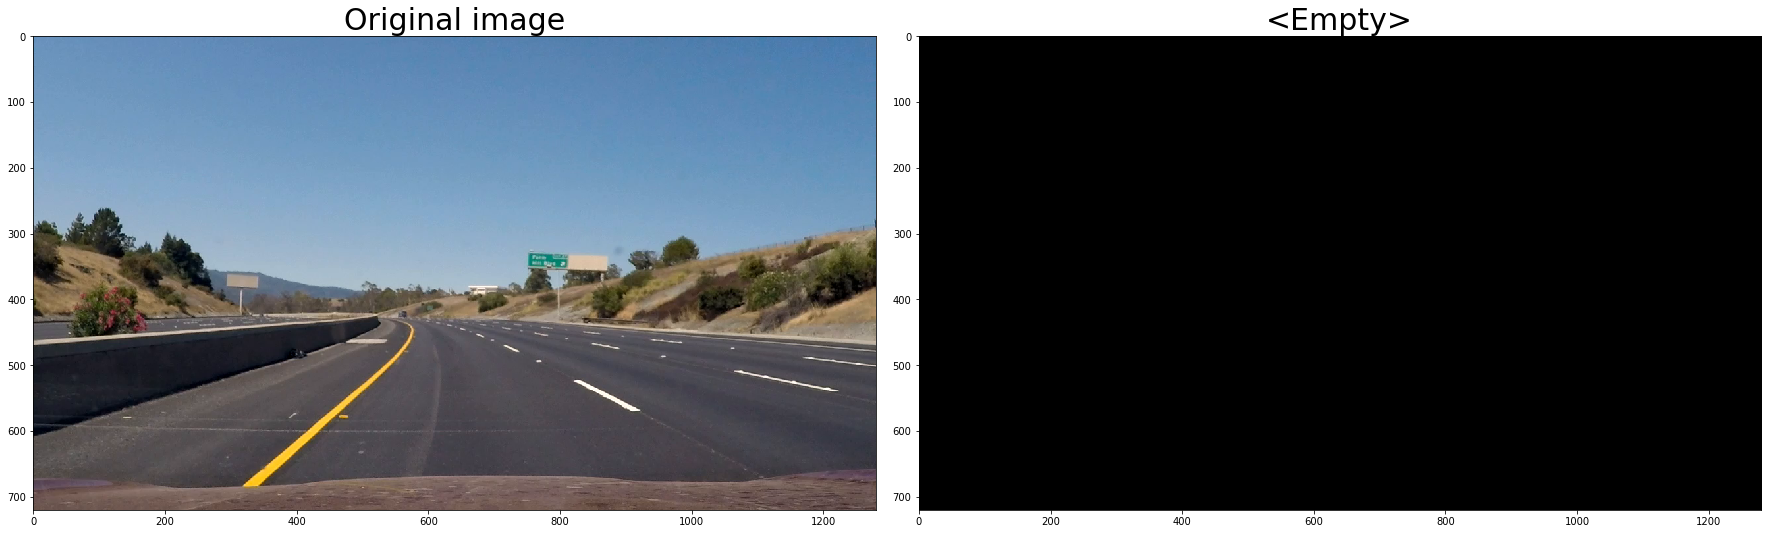

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


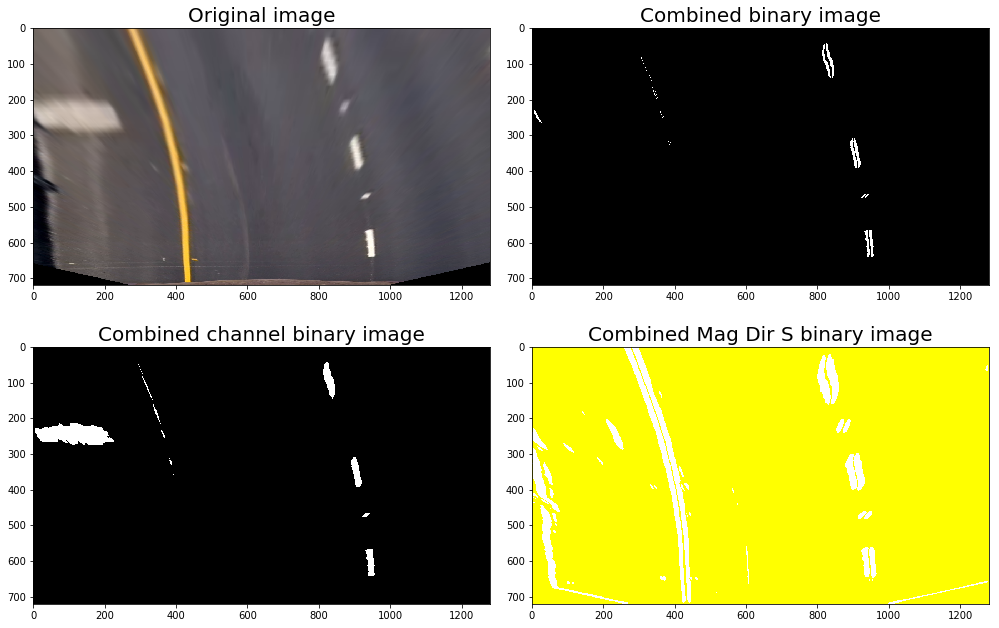

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


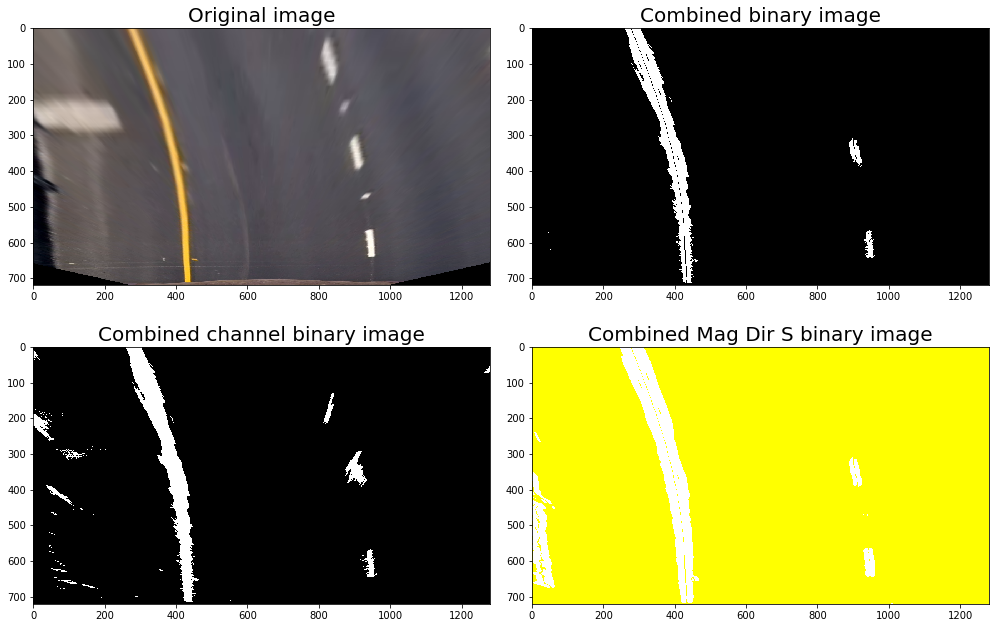

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
cbi (combine binary image)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280)
Binary operator used for combining: OR


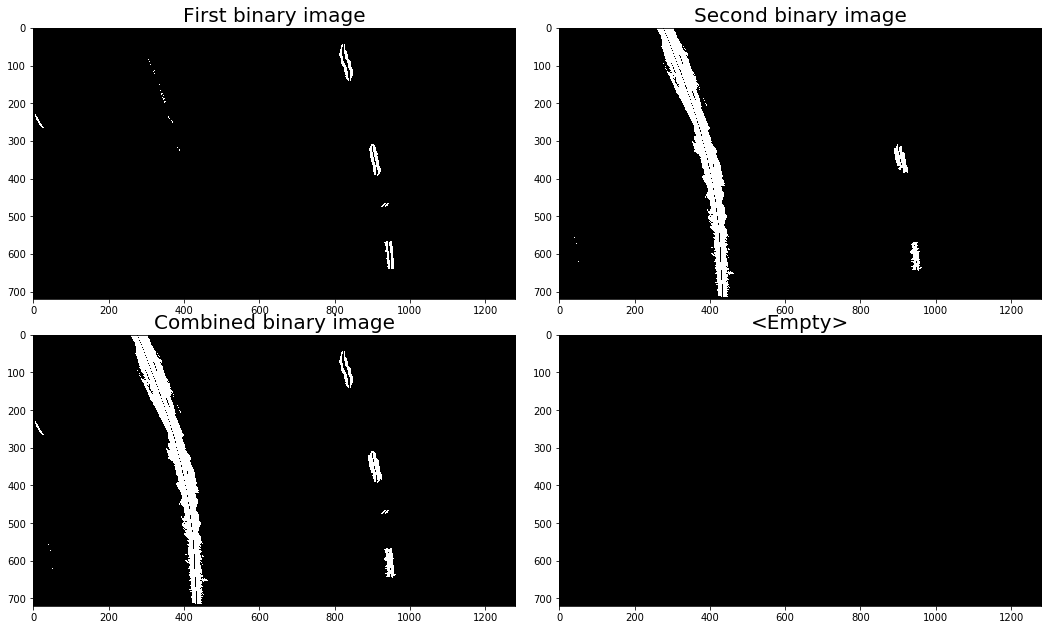

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Finding lanes lines without prior knowledge...
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
sliding_window_detect
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [437, 427, 420, 411, 401, 377, 349, 323, 296]
Values in y: [676, 598, 521, 439, 358, 279, 199, 121, 39]
Polynomial: [-3.04418173e-04  4.38146961e-01  2.77193840e+02]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [931, 936, 917, 900, 884, 821, 809]
Values in y: [680, 592, 440, 352, 280, 91, 40]
Polynomial: [-3.21003232e-04  4.32242368e-01  7.88484344e+02]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = 

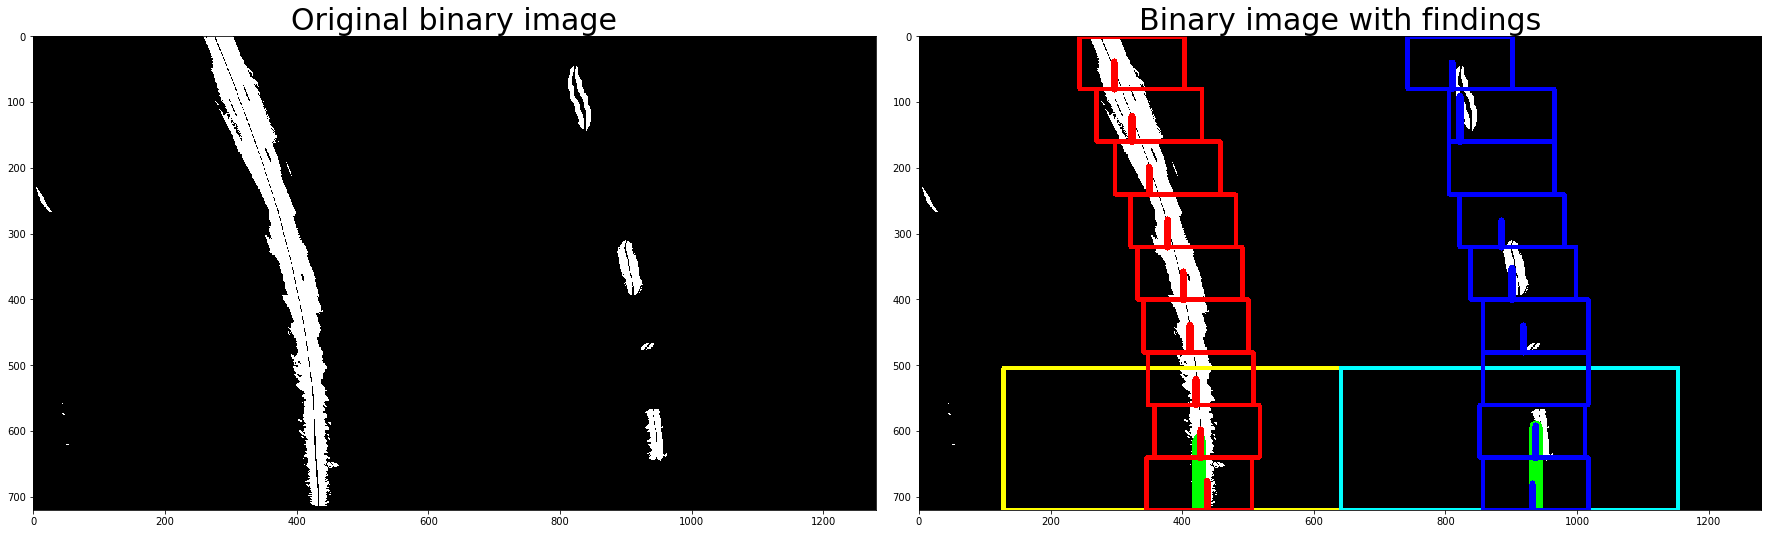

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Success!
Processing image size: (720, 1280, 3)


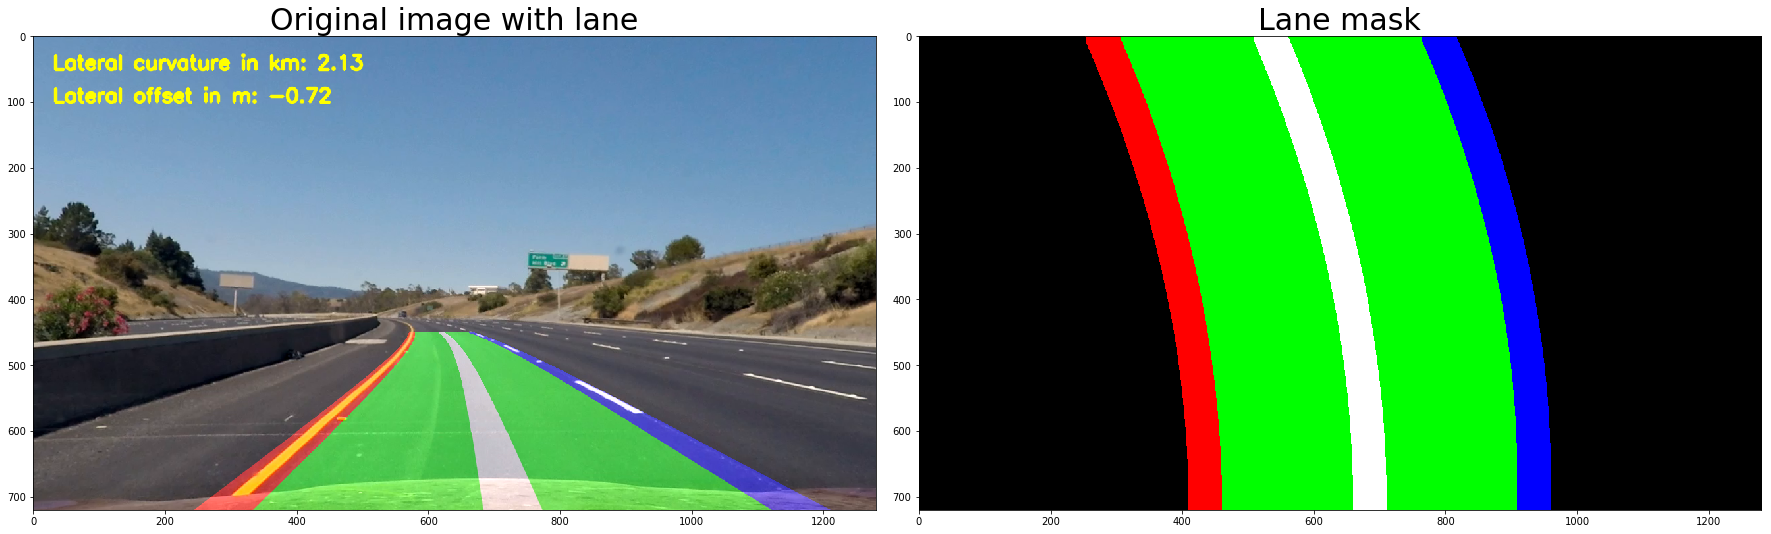

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing frame: 200
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
process_video_frame
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


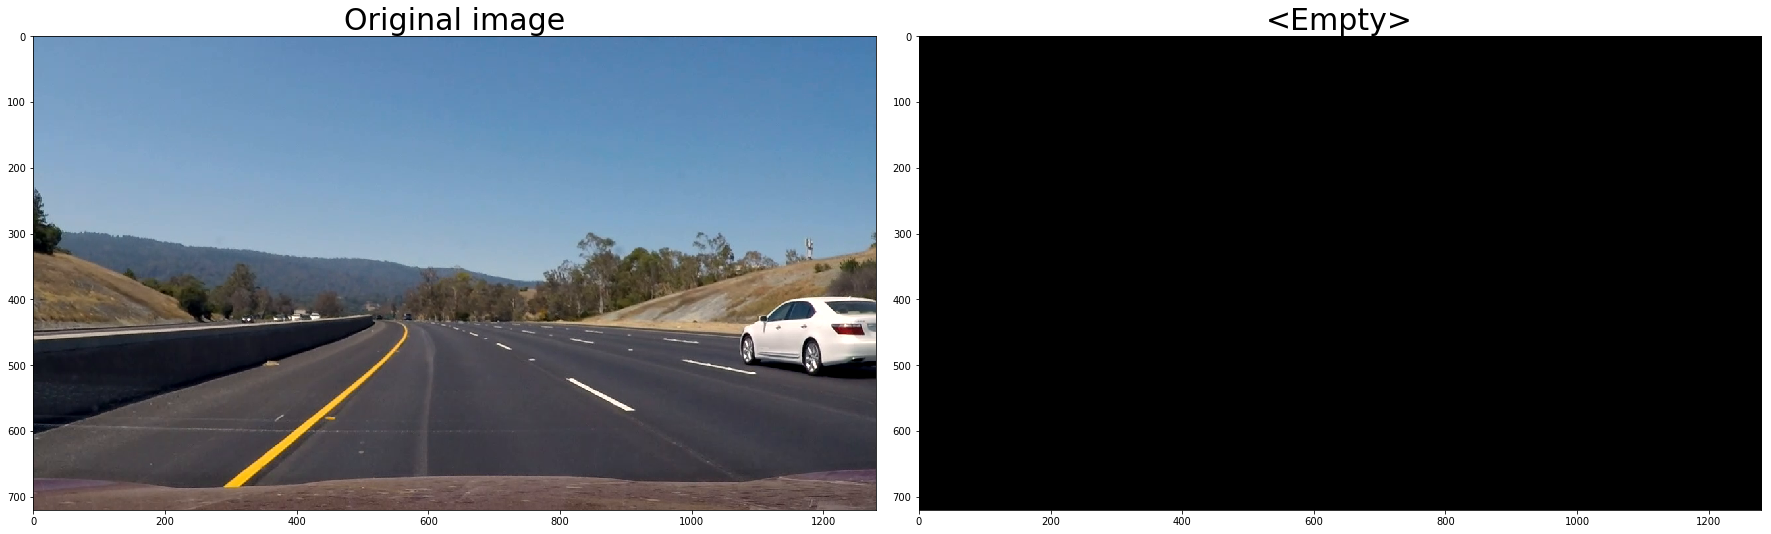

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


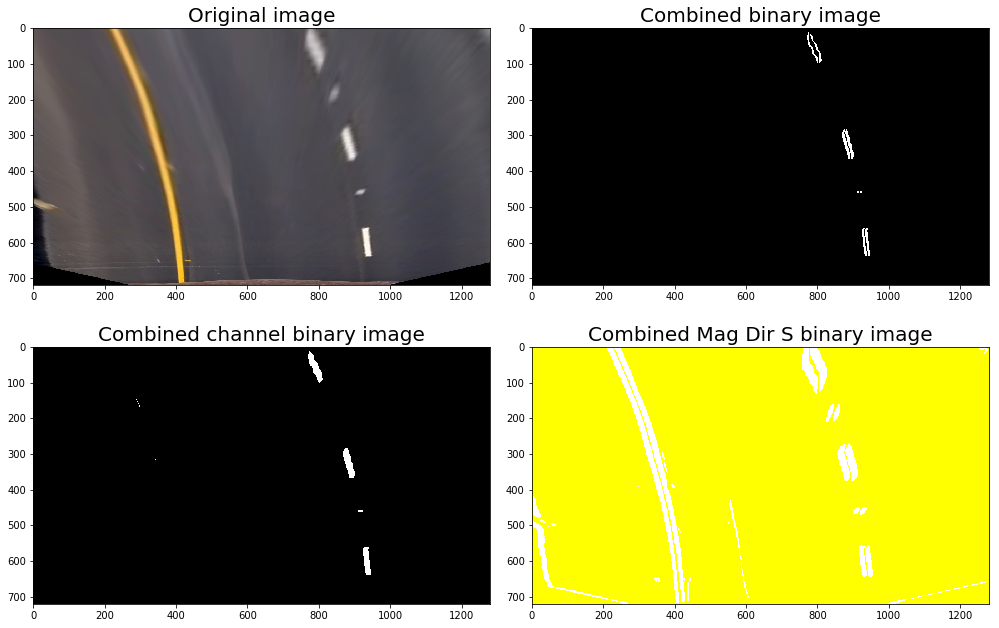

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


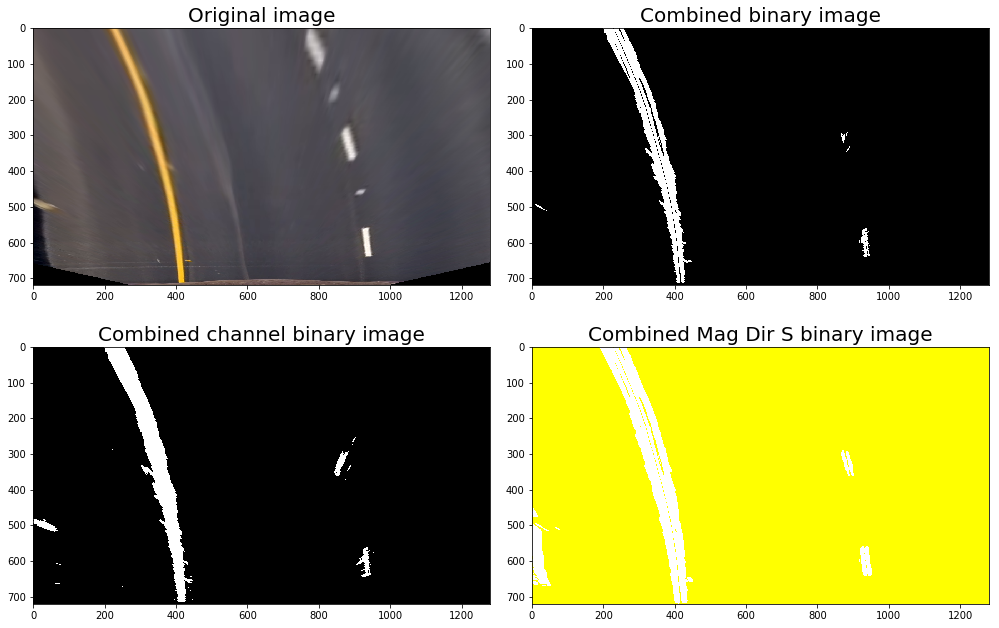

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
cbi (combine binary image)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280)
Binary operator used for combining: OR


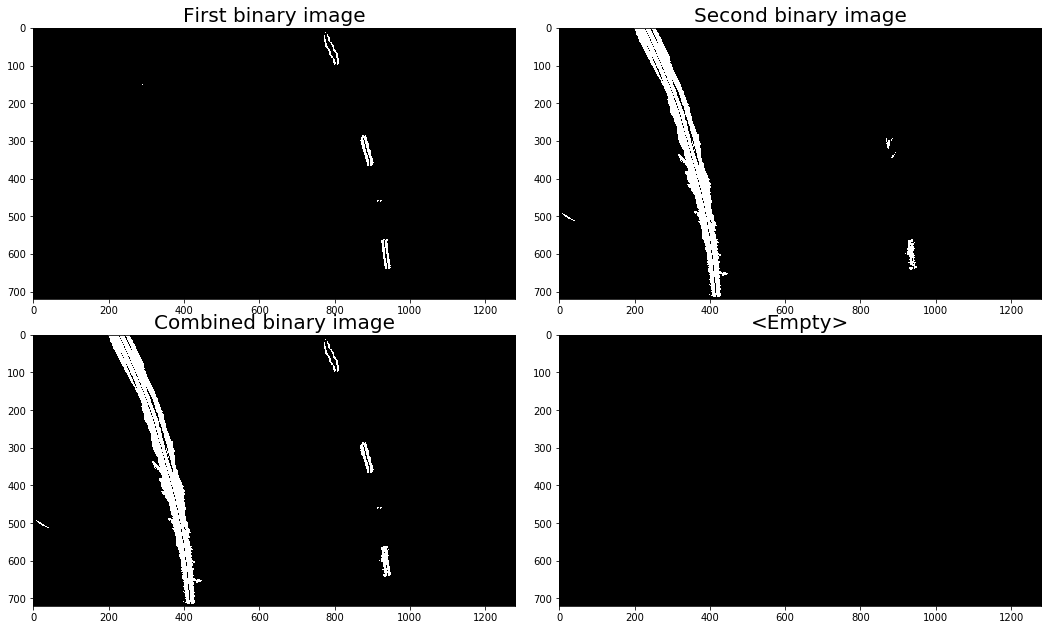

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Finding lanes lines with prior knowledge...
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
sliding_window_detect
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [420, 404, 390, 376, 357, 338, 314, 280, 244]
Values in y: [677, 600, 520, 439, 362, 285, 204, 119, 44]
Polynomial: [-2.57869805e-04  4.51797913e-01  2.28302694e+02]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [916, 923, 899, 877, 865, 785, 783]
Values in y: [680, 584, 440, 329, 280, 120, 41]
Polynomial: [-3.64088828e-04  4.98505080e-01  7.50217742e+02]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = 

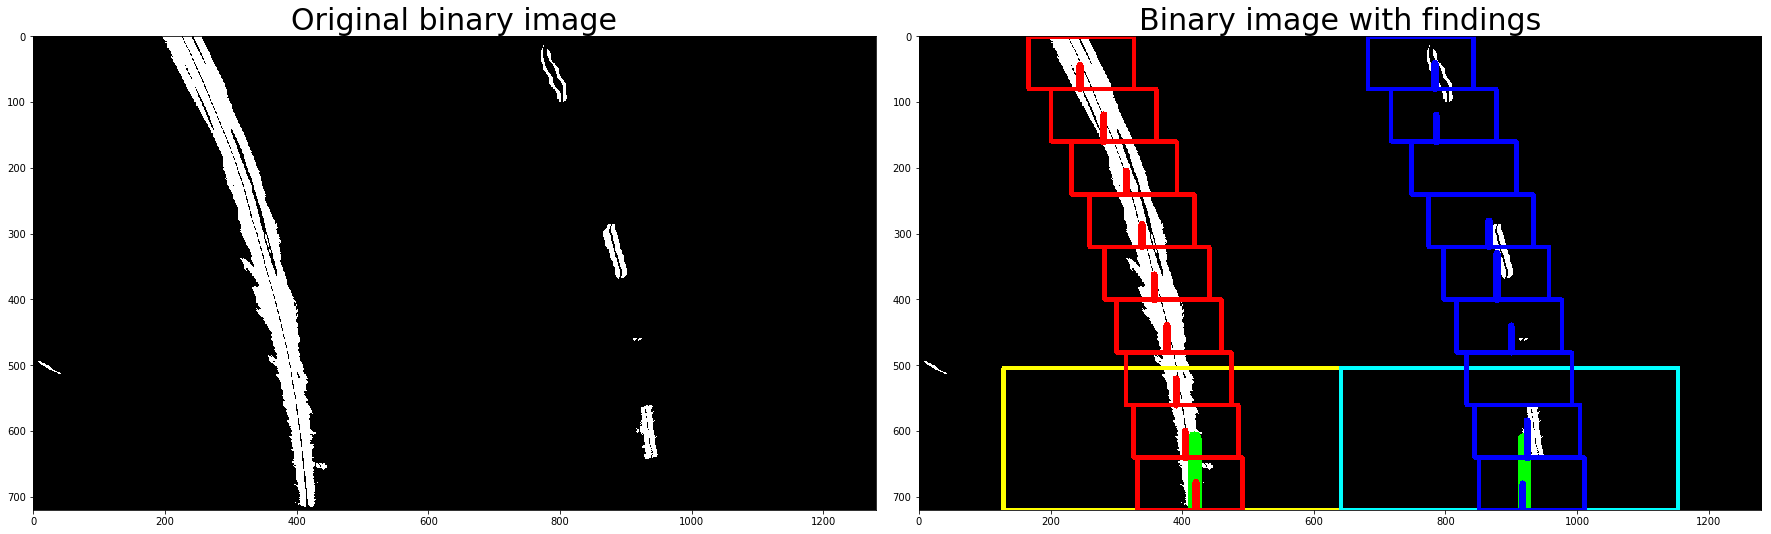

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Success!
Processing image size: (720, 1280, 3)


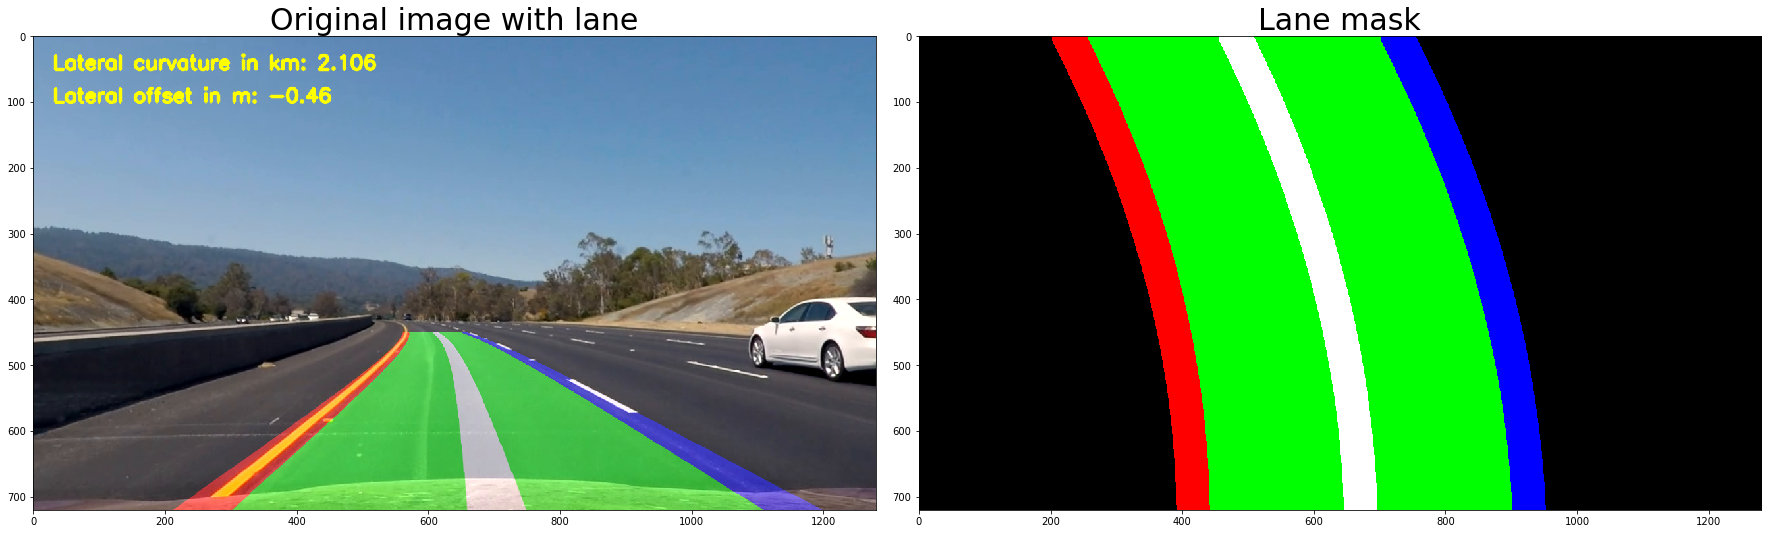

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing frame: 400
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
process_video_frame
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


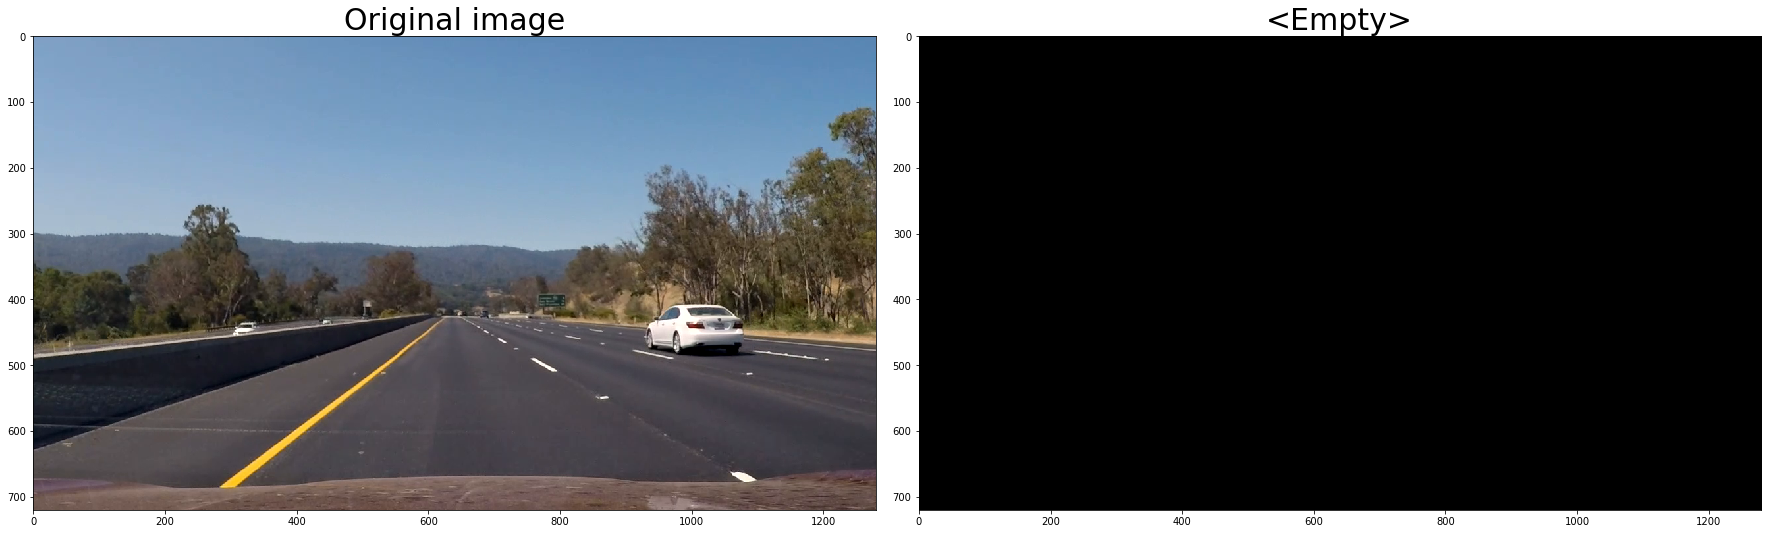

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


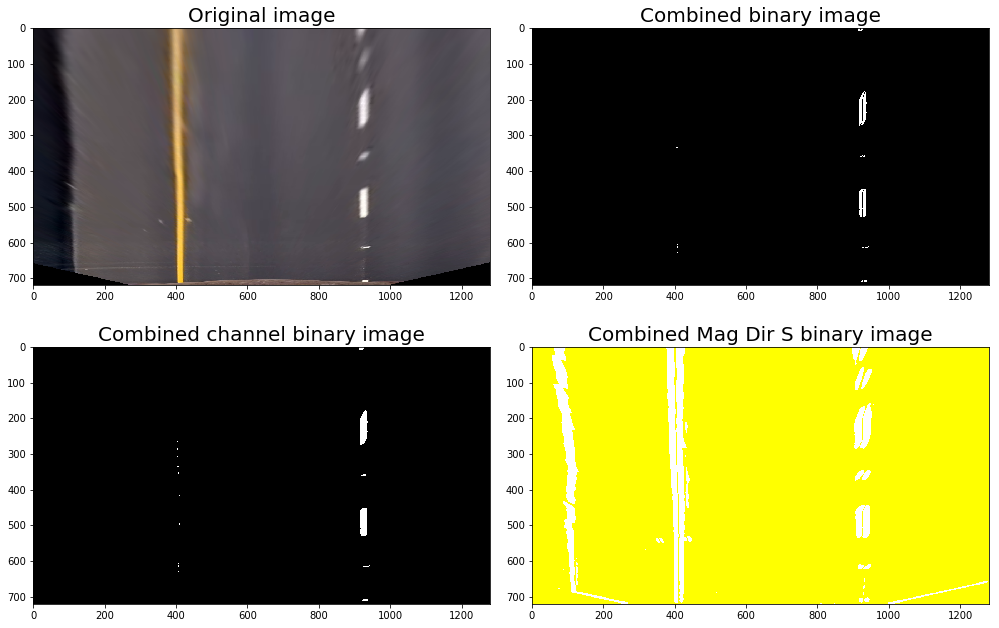

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


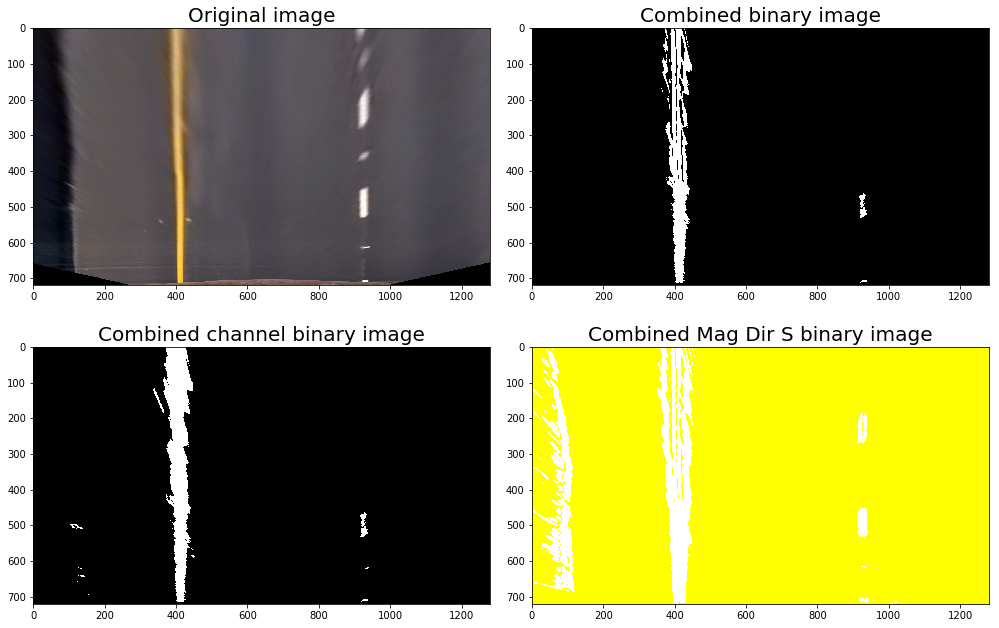

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
cbi (combine binary image)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280)
Binary operator used for combining: OR


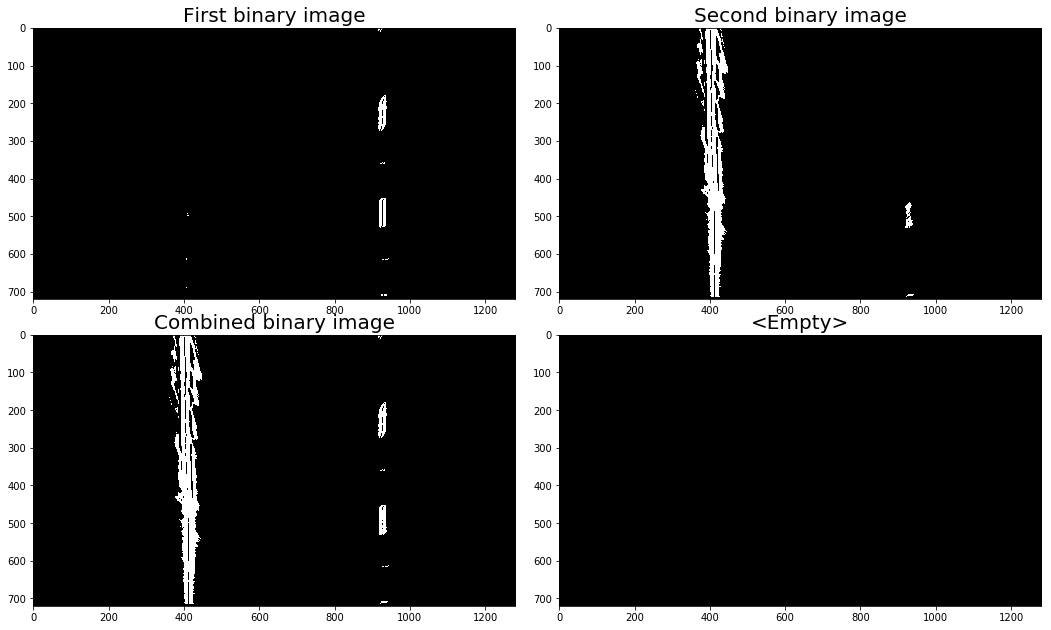

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Finding lanes lines with prior knowledge...
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
sliding_window_detect
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [404, 413, 415, 411, 408, 405, 414, 414, 411]
Values in y: [676, 599, 519, 414, 359, 240, 185, 110, 40]
Polynomial: [-1.01747653e-05  2.98148461e-03  4.11200238e+02]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [914, 917, 913, 910, 906, 910, 911, 904]
Values in y: [680, 600, 520, 440, 360, 280, 200, 40]
Polynomial: [2.68075980e-06 1.38567927e-02 9.04706145e+02]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = =

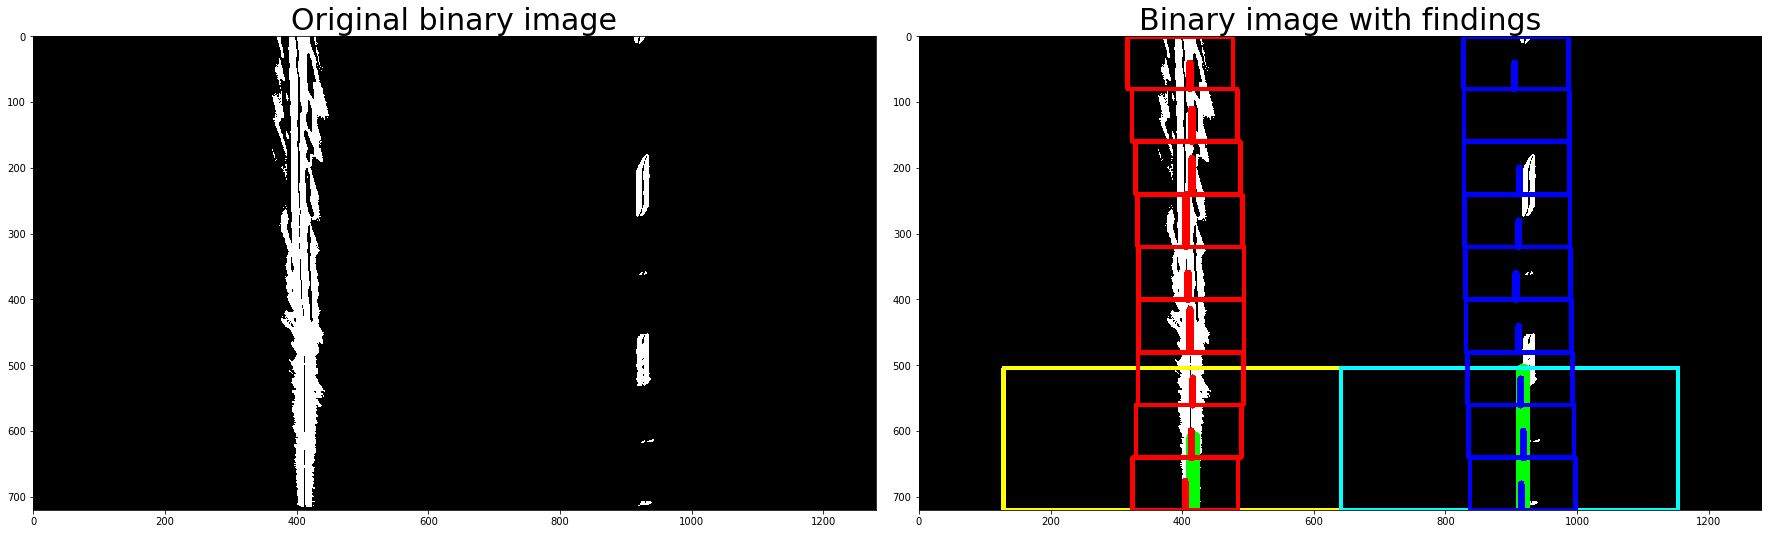

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Success!
Processing image size: (720, 1280, 3)


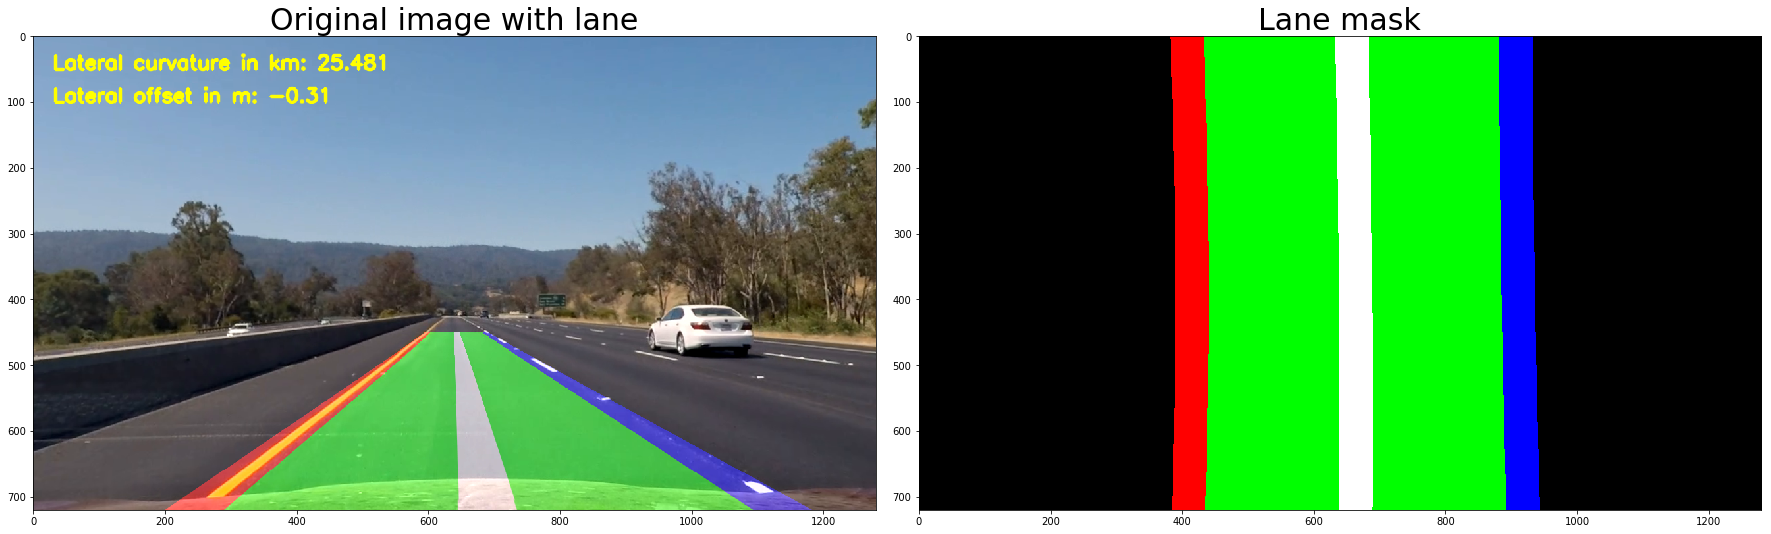

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing frame: 600
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
process_video_frame
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


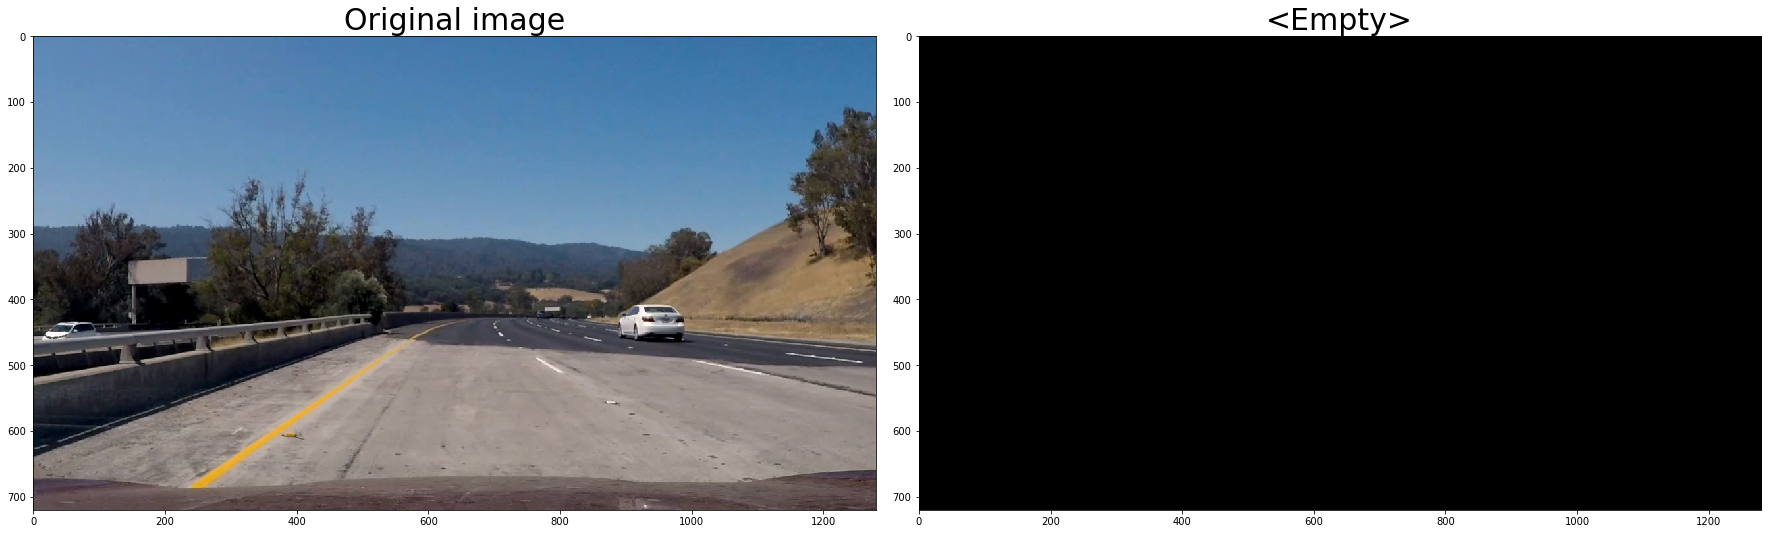

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


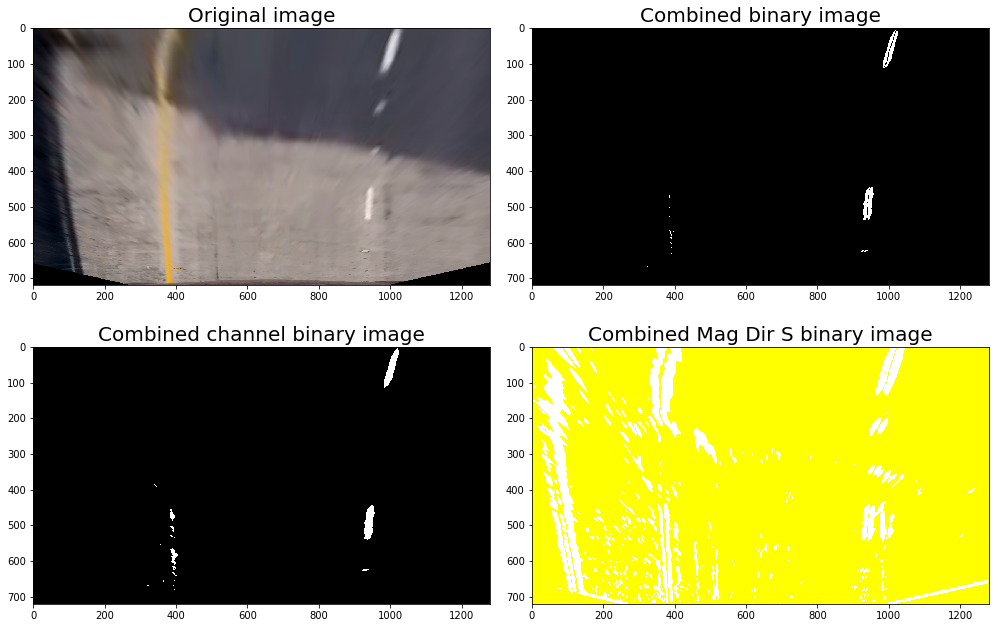

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


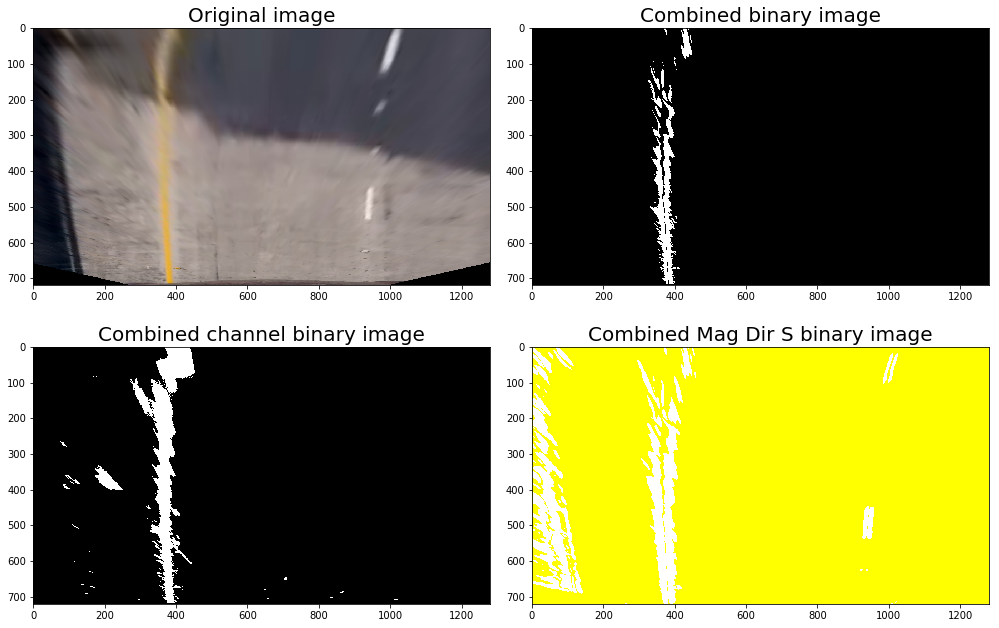

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
cbi (combine binary image)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280)
Binary operator used for combining: OR


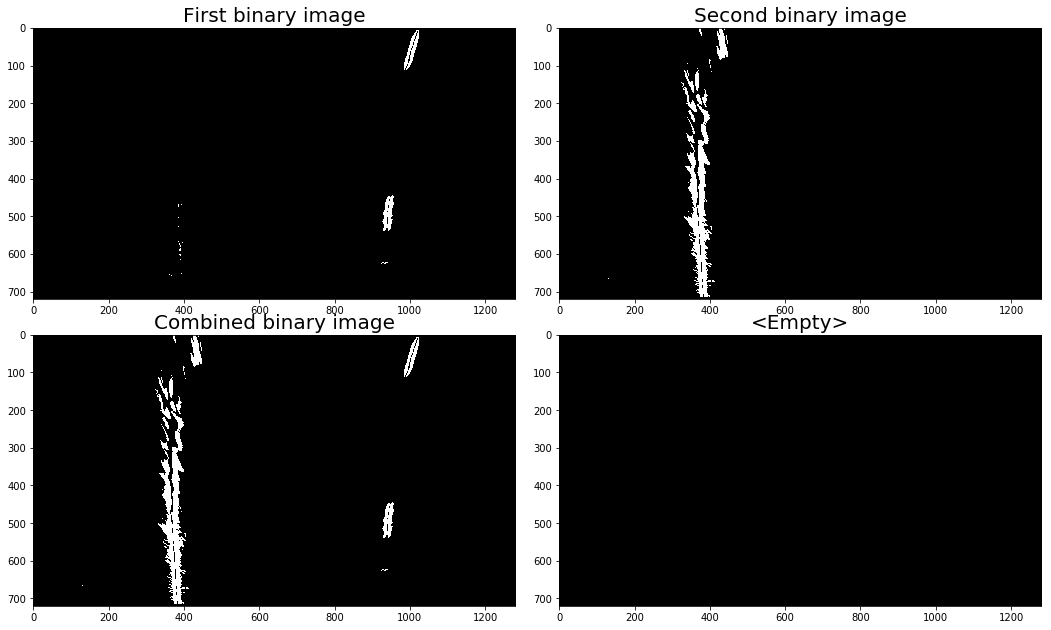

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Finding lanes lines with prior knowledge...
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
sliding_window_detect
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No line centers found.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No success!
Finding lanes lines with prior starting position...
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
sliding_window_detect
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No line centers found.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
No success!
Finding lanes lines without prior knowledge...
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
sliding_window_detect
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [382, 375, 368, 366, 365, 3

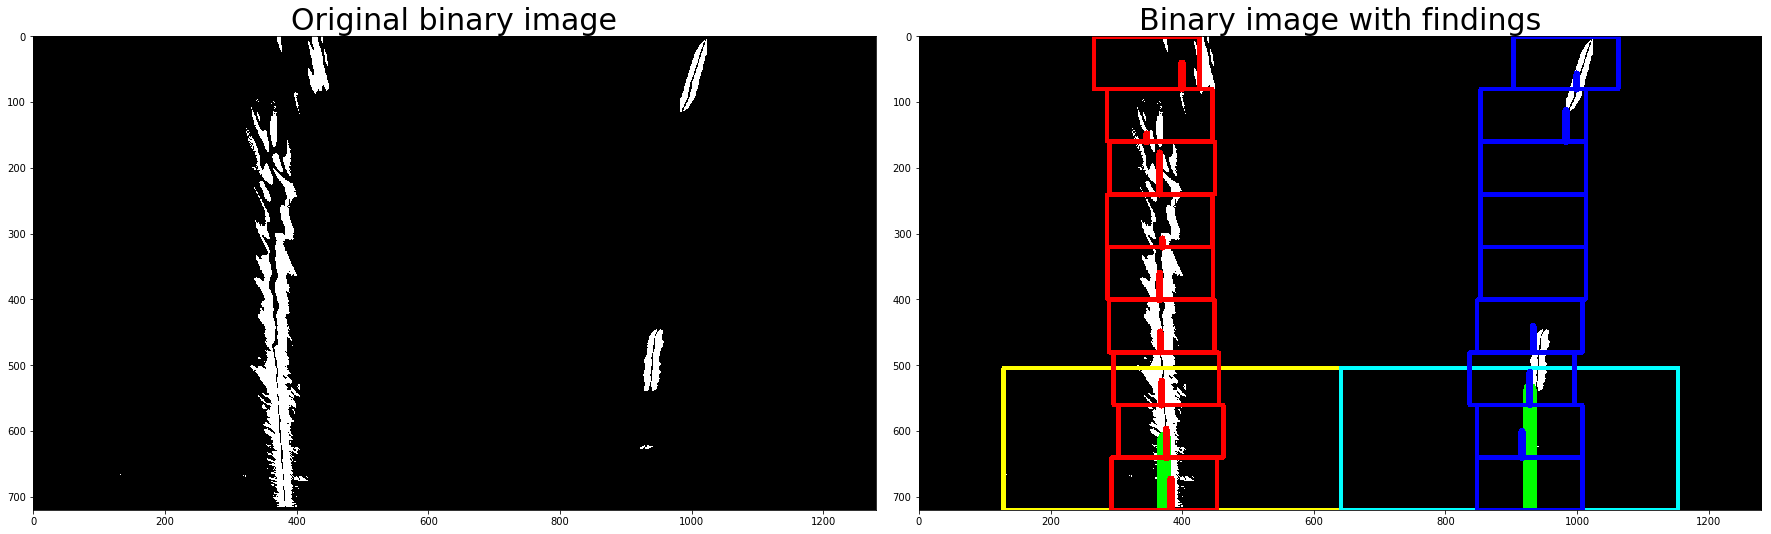

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Success!
Processing image size: (720, 1280, 3)


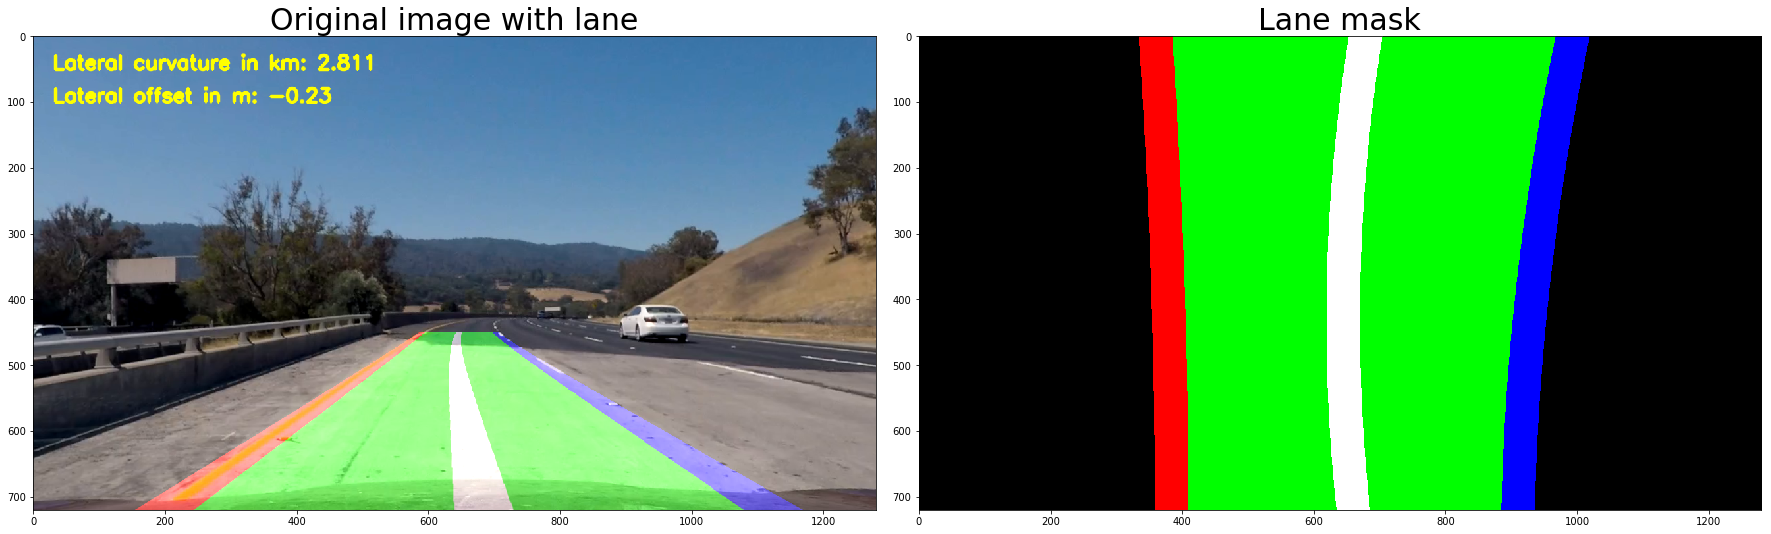

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing frame: 800
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
process_video_frame
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


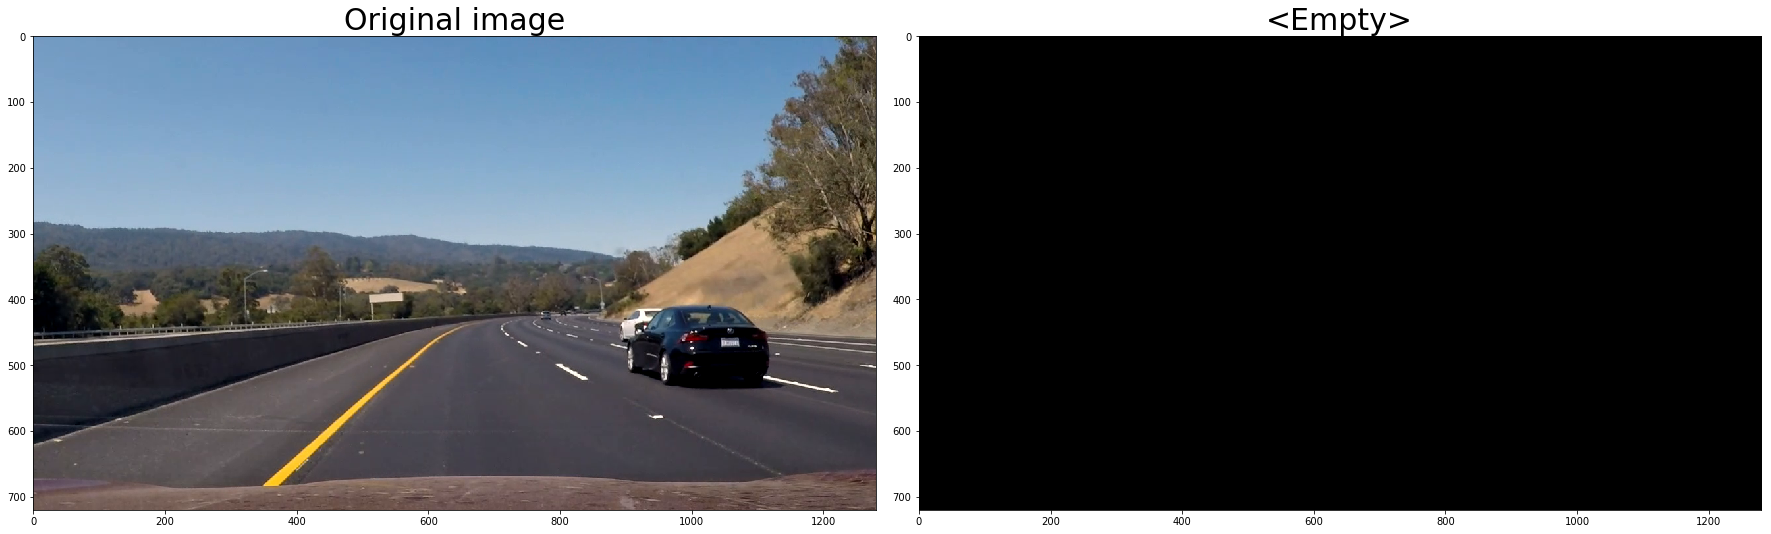

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


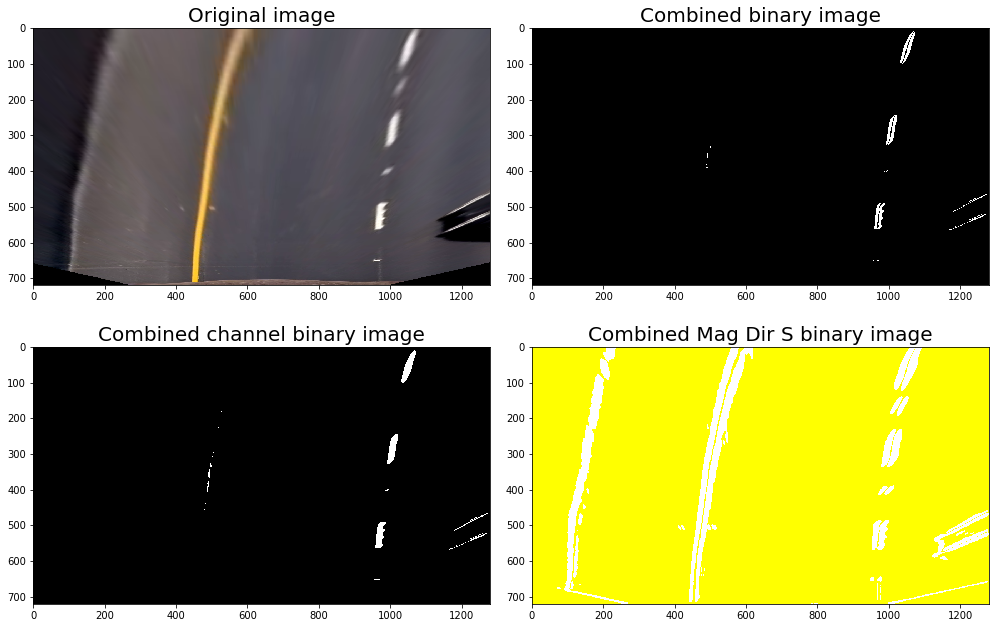

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
create_binary_image
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280, 3)


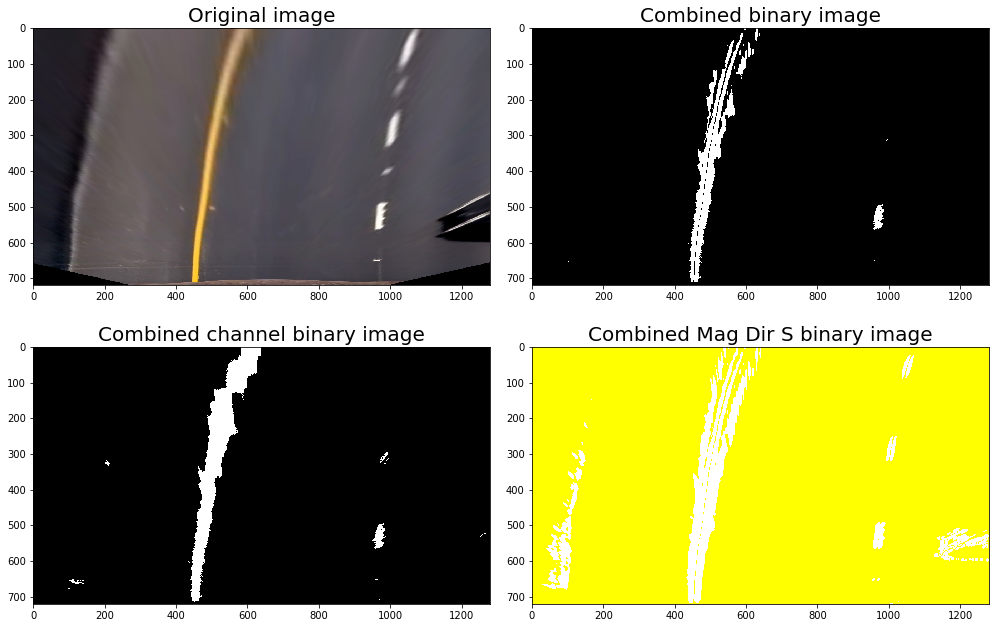

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
cbi (combine binary image)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Processing image size: (720, 1280)
Binary operator used for combining: OR


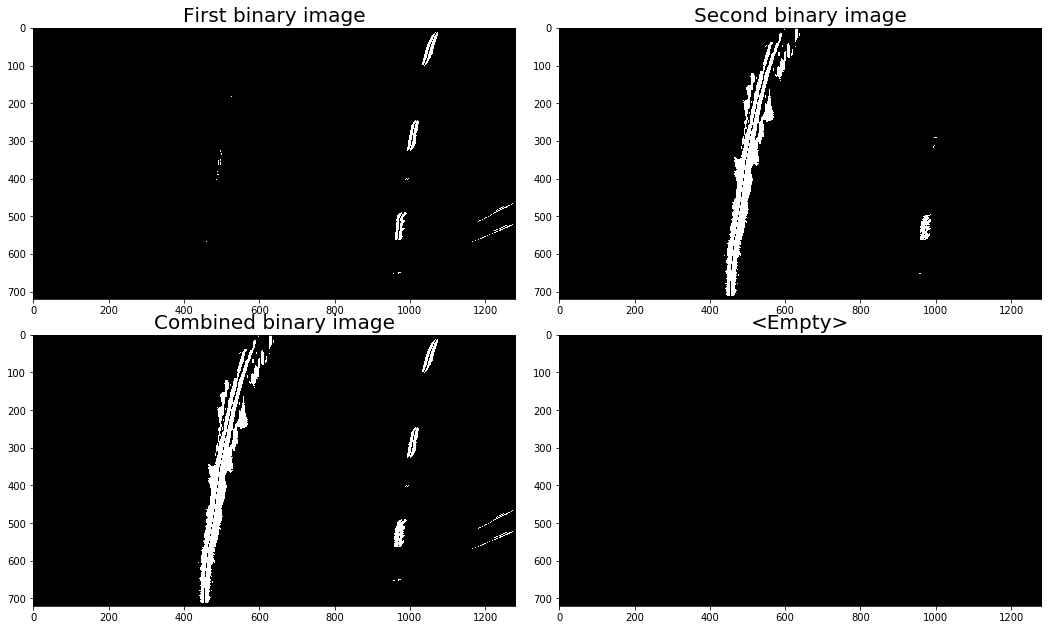

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Finding lanes lines with prior knowledge...
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
sliding_window_detect
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [451, 461, 476, 485, 492, 514, 537, 534, 575]
Values in y: [676, 600, 521, 440, 357, 284, 184, 137, 55]
Polynomial: [ 1.62287143e-04 -3.02692125e-01  5.84344584e+02]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
calculate_polynomial
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Values in x: [949, 951, 964, 970, 981, 996, 1028, 1047]
Values in y: [680, 600, 531, 440, 360, 306, 120, 56]
Polynomial: [ 1.53024300e-04 -2.69135915e-01  1.06037173e+03]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
= 

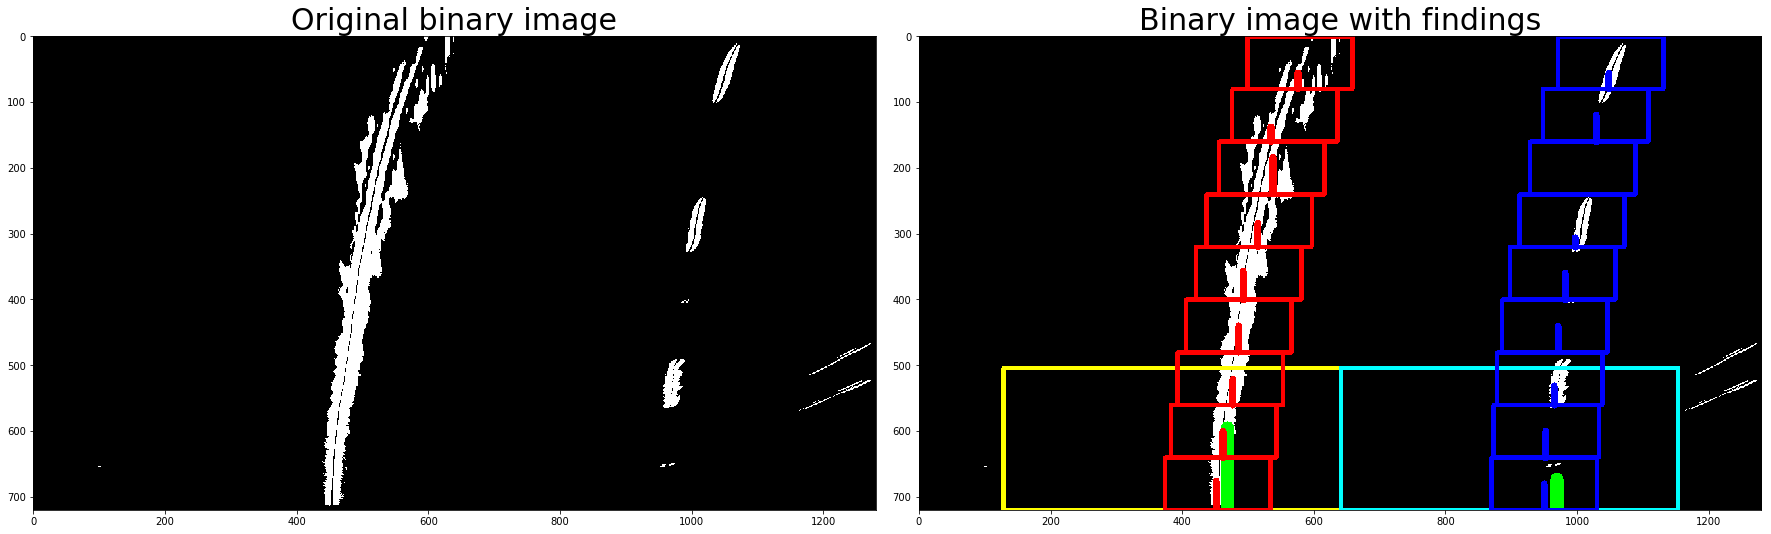

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Success!
Processing image size: (720, 1280, 3)


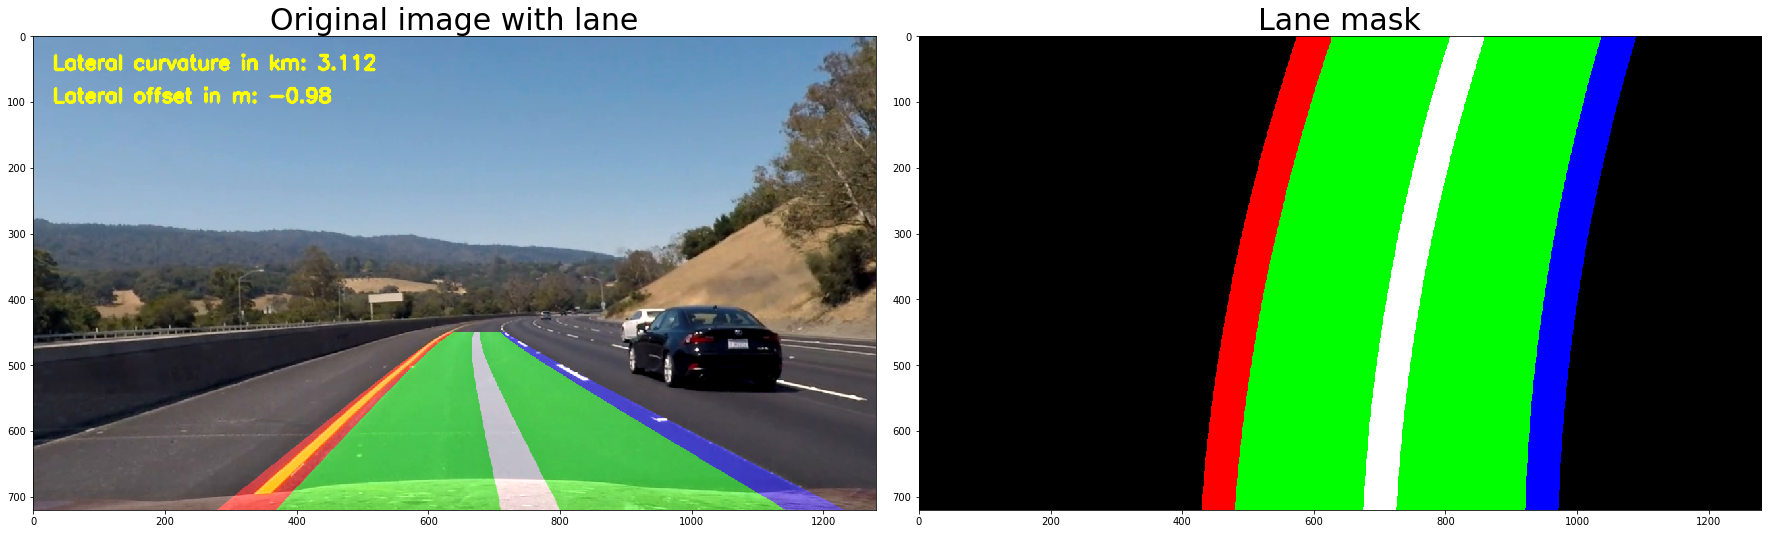

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


In [ ]:
### main pipeline ###

# set up the camera
mtx, dist, rvecs, tvecs, M, N, xm_per_pix, ym_per_pix = camera_setup(bdisplay = False)

# process the video
videofilename1 = './project_video.mp4'
outputfilename1 = './output_images/output.mp4'
process_video(videofilename1, outputfilename1, mtx, dist, M, xm_per_pix, ym_per_pix, bdisplay = True, displayfrequency = 200, bdisplaydetails = True, bdisplaydepth = False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(outputfilename1))

In [ ]:
### challenge pipeline ###

# process the video
videofilename2 = './challenge_video.mp4'
outputfilename2 = './output_images/output_challenge.mp4'
process_video(videofilename2, outputfilename2, mtx, dist, M, xm_per_pix, ym_per_pix, bdisplay = True, displayfrequency = 100, bdisplaydetails = False, bdisplaydepth = False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(outputfilename2))

In [ ]:
### harder challenge pipeline ###

# process the video
videofilename3 = './harder_challenge_video.mp4'
outputfilename3 = './output_images/output_harder_challenge.mp4'
process_video(videofilename3, outputfilename3, mtx, dist, M, xm_per_pix, ym_per_pix, bdisplay = True, displayfrequency = 200, bdisplaydetails = False, bdisplaydepth = False)

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format(outputfilename3))

## Pipeline test

The following code contains the pipeline to test all functions with the test images.

In [ ]:
### test pipeline ###

# set up the camera
mtx, dist, rvecs, tvecs, M, N, xm_per_pix, ym_per_pix = camera_setup(bdisplay = True)

# get a list of test images
testsubfolder = 'test_images'
calimagemask = '*.jpg'
fileimages = glob.glob(os.path.join('.', testsubfolder, calimagemask))

OldLeftLine = Line()
OldRightLine = Line()
OldAllLines = Line()
OldLane = Lane()

for fileimage in fileimages:
    image = mpimg.imread(fileimage)
    
    ret, outputframe, breusepoly, breusestart, OldLeftLine, OldRightLine, OldAllLines, OldLane = process_video_frame(
        image, mtx, dist, M, xm_per_pix, ym_per_pix, OldLeftLine, OldRightLine, OldAllLines, OldLane, 
        bsmooth = False, bdisplay = True, bdisplaydetails = True, bdisplaydepth = False)